# Importation Data

In [1]:
import pandas as pd 
import yfinance as yf 
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn import metrics
import plotly.express as px
import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras_tuner import RandomSearch
from pathlib import Path
from tensorflow.keras import  mixed_precision, layers

In [2]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("CPU devices:", tf.config.list_physical_devices('CPU'))
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# Mixed precision (gain VRAM + vitesse si GPU récent)
mixed_precision.set_global_policy('mixed_float16')

# Optional: limiter verbosité TF
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

TF version: 2.20.0
CPU devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU devices: []


In [3]:
daily_data = pd.DataFrame()
data_SP500 = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_SP500.parquet')
data_NDX = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_NASDAQ.parquet')
data_MP = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_MP.parquet')
data_Crypto = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_Crypto.parquet')
data_SmallCap_US = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_SmallCap_US.parquet')
data_MidCap_US = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_MidCap_US.parquet')
data_LargeCap_Chine = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_LargeCap_Chine.parquet')
daily_data = pd.concat([data_SP500, data_NDX, data_MP, data_Crypto, data_SmallCap_US, data_MidCap_US, data_LargeCap_Chine], ignore_index=True)
daily_data = daily_data.drop_duplicates(subset=['Ticker', 'Date'])
daily_data

Price          Date      Close       High        Low       Open       Volume  \
0        1999-11-18  26.399939  29.999932  23.999944  27.299935   62546380.0   
1        1999-11-19  24.224939  25.799935  23.887440  25.762434   15234146.0   
2        1999-11-22  26.399939  26.399939  24.037443  24.787442    6577870.0   
3        1999-11-23  23.999937  26.174932  23.999937  25.499933    5975611.0   
4        1999-11-24  24.637444  25.162443  23.999944  24.074945    4843231.0   
...             ...        ...        ...        ...        ...          ...   
10582616 2025-09-11   6.830000   6.840000   6.730000   6.820000  146290475.0   
10582617 2025-09-12   6.940000   7.140000   6.830000   6.830000  322089159.0   
10582618 2025-09-15   6.970000   7.040000   6.820000   6.920000  228923025.0   
10582619 2025-09-16   7.040000   7.050000   6.890000   6.950000  222680538.0   
10582620 2025-09-17   7.050000   7.080000   6.930000   6.830000  166363987.0   

Price        Ticker  Adj Close  
0                 A        NaN  
1                 A        NaN  
2                 A        NaN  
3                 A        NaN  
4                 A        NaN  
...             ...        ...  
10582616  000002.SZ        NaN  
10582617  000002.SZ        NaN  
10582618  000002.SZ        NaN  
10582619  000002.SZ        NaN  
10582620  000002.SZ        NaN  

[10041105 rows x 8 columns]

In [4]:
#start_date = "1990-01-03"
#final_date = "2025-07-16"

daily_data = daily_data.sort_values(by=['Date'], ascending = True)

# Accéder à l'index de la colonne 'Date'
#s = daily_data[daily_data['Date'] == start_date].index[0]
#f = daily_data[daily_data['Date'] == final_date].index[0]

# Filtrer les données à partir de la date spécifiée
#daily_data = daily_data.loc[s:]

daily_data

Price          Date       Close        High         Low        Open  \
4327236  1962-01-02    0.646239    0.650278    0.642200    0.642200   
10245619 1962-01-02    1.479799    1.488287    1.479799    1.479799   
10245620 1962-01-03    1.502435    1.502435    1.476970    1.479800   
4327237  1962-01-03    0.658355    0.658355    0.650278    0.650278   
4327238  1962-01-04    0.654317    0.671482    0.654317    0.658356   
...             ...         ...         ...         ...         ...   
8214074  2025-09-17  179.255005  179.875000  176.110001  176.919998   
9610492  2025-09-17   17.415001   17.470100   17.100000   17.219999   
10045123 2025-09-17    9.630000    9.805000    9.625000    9.715000   
7471319  2025-09-17  208.039993  211.160004  206.690094  211.399994   
10582620 2025-09-17    7.050000    7.080000    6.930000    6.830000   

Price          Volume     Ticker  Adj Close  
4327236       51233.0        XRX        NaN  
10245619      55930.0         AA        NaN  
10245620      74906.0         AA        NaN  
4327237       51233.0        XRX        NaN  
4327238      198099.0        XRX        NaN  
...               ...        ...        ...  
8214074      312954.0        MOH        NaN  
9610492     1054987.0         CC        NaN  
10045123     684628.0       AMRX        NaN  
7471319       23643.0        SXI        NaN  
10582620  166363987.0  000002.SZ        NaN  

[10041105 rows x 8 columns]

In [5]:
#Date au format Date
daily_data['Date'] = pd.to_datetime(daily_data['Date'])

# Définir la colonne 'Date' comme index
daily_data.set_index('Date', inplace=True)

daily_data

Price            Close        High         Low        Open       Volume  \
Date                                                                      
1962-01-02    0.646239    0.650278    0.642200    0.642200      51233.0   
1962-01-02    1.479799    1.488287    1.479799    1.479799      55930.0   
1962-01-03    1.502435    1.502435    1.476970    1.479800      74906.0   
1962-01-03    0.658355    0.658355    0.650278    0.650278      51233.0   
1962-01-04    0.654317    0.671482    0.654317    0.658356     198099.0   
...                ...         ...         ...         ...          ...   
2025-09-17  179.255005  179.875000  176.110001  176.919998     312954.0   
2025-09-17   17.415001   17.470100   17.100000   17.219999    1054987.0   
2025-09-17    9.630000    9.805000    9.625000    9.715000     684628.0   
2025-09-17  208.039993  211.160004  206.690094  211.399994      23643.0   
2025-09-17    7.050000    7.080000    6.930000    6.830000  166363987.0   

Price          Ticker  Adj Close  
Date                              
1962-01-02        XRX        NaN  
1962-01-02         AA        NaN  
1962-01-03         AA        NaN  
1962-01-03        XRX        NaN  
1962-01-04        XRX        NaN  
...               ...        ...  
2025-09-17        MOH        NaN  
2025-09-17         CC        NaN  
2025-09-17       AMRX        NaN  
2025-09-17        SXI        NaN  
2025-09-17  000002.SZ        NaN  

[10041105 rows x 7 columns]

In [6]:

# Rééchantillonner les données en fréquence Annuelle
yearly_data = daily_data.groupby("Ticker").resample('YE').agg({
    'Open': 'first',   # Premier prix d'ouverture du mois
    'High': 'max',     # Plus haut du mois
    'Low': 'min',      # Plus bas du mois
    'Close': 'last',   # Dernier prix de clôture du mois
    'Volume': 'sum',   # Somme du volume sur le mois
}).reset_index()
yearly_data

Price     Ticker       Date       Open       High        Low      Close  \
0      000002.SZ 1991-12-31   0.136292   0.167421   0.044994   0.129228   
1      000002.SZ 1992-12-31   0.128705   0.455805   0.114056   0.445760   
2      000002.SZ 1993-12-31   0.449527   0.459572   0.238731   0.338753   
3      000002.SZ 1994-12-31   0.338753   0.344414   0.113719   0.155781   
4      000002.SZ 1995-12-31   0.149809   0.184340   0.106398   0.107632   
...          ...        ...        ...        ...        ...        ...   
41197       ZYME 2021-12-31  48.000000  59.029999  14.900000  16.389999   
41198       ZYME 2022-12-31  16.490000  17.270000   4.110000   7.860000   
41199       ZYME 2023-12-31   7.950000  10.990000   6.015000  10.390000   
41200       ZYME 2024-12-31  10.260000  17.700001   7.970000  14.640000   
41201       ZYME 2025-12-31  14.660000  17.070000   9.030000  16.360001   

Price        Volume  
0      1.679247e+09  
1      9.160604e+09  
2      9.247587e+09  
3      8.603484e+09  
4      1.607695e+09  
...             ...  
41197  1.347241e+08  
41198  3.245733e+08  
41199  1.397208e+08  
41200  1.532948e+08  
41201  9.277862e+07  

[41202 rows x 7 columns]

In [7]:

# Rééchantillonner les données en fréquence mensuelle
monthly_data = daily_data.groupby("Ticker").resample('ME').agg({
    'Open': 'first',   # Premier prix d'ouverture du mois
    'High': 'max',     # Plus haut du mois
    'Low': 'min',      # Plus bas du mois
    'Close': 'last',   # Dernier prix de clôture du mois
    'Volume': 'sum',   # Somme du volume sur le mois
}).reset_index()
monthly_data


Price      Ticker       Date       Open       High        Low      Close  \
0       000002.SZ 1991-01-31   0.136292   0.136292   0.126525   0.126525   
1       000002.SZ 1991-02-28   0.126525   0.133675   0.126525   0.131583   
2       000002.SZ 1991-03-31   0.130885   0.130885   0.114928   0.114928   
3       000002.SZ 1991-04-30   0.114928   0.114928   0.101586   0.101586   
4       000002.SZ 1991-05-31   0.101586   0.101586   0.095831   0.098447   
...           ...        ...        ...        ...        ...        ...   
480344       ZYME 2025-05-31  12.950000  13.230000  10.860000  11.430000   
480345       ZYME 2025-06-30  11.500000  13.435000  11.320000  12.550000   
480346       ZYME 2025-07-31  12.450000  15.000000  12.160000  12.560000   
480347       ZYME 2025-08-31  12.400000  15.380000  11.510000  14.810000   
480348       ZYME 2025-09-30  13.910000  16.545000  13.600000  16.360001   

Price       Volume  
0        2821642.0  
1       39996433.0  
2       18016405.0  
3        5366110.0  
4       74809688.0  
...            ...  
480344   9389500.0  
480345  10303500.0  
480346   8788100.0  
480347   9711700.0  
480348   5821817.0  

[480349 rows x 7 columns]

In [8]:

# Rééchantillonner les données en fréquence semestrielle
weekly_data = daily_data.groupby("Ticker").resample('W').agg({
    'Open': 'first',   # Premier prix d'ouverture du mois
    'High': 'max',     # Plus haut du mois
    'Low': 'min',      # Plus bas du mois
    'Close': 'last',   # Dernier prix de clôture du mois
    'Volume': 'sum',   # Somme du volume sur le mois
}).reset_index()
weekly_data


Price       Ticker       Date       Open       High        Low      Close  \
0        000002.SZ 1991-01-06   0.136292   0.136292   0.133501   0.133501   
1        000002.SZ 1991-01-13   0.134896   0.134896   0.132106   0.132106   
2        000002.SZ 1991-01-20   0.130711   0.130711   0.128269   0.128269   
3        000002.SZ 1991-01-27   0.128269   0.128269   0.128269   0.128269   
4        000002.SZ 1991-02-03   0.128269   0.128269   0.126525   0.126525   
...            ...        ...        ...        ...        ...        ...   
2083060       ZYME 2025-08-24  14.370000  15.380000  13.480000  15.100000   
2083061       ZYME 2025-08-31  15.110000  15.350000  14.540000  14.810000   
2083062       ZYME 2025-09-07  13.910000  15.280000  13.600000  15.050000   
2083063       ZYME 2025-09-14  15.000000  16.370001  14.690000  15.740000   
2083064       ZYME 2025-09-21  15.750000  16.545000  15.490000  16.360001   

Price       Volume  
0        1679683.0  
1         615328.0  
2         194021.0  
3              0.0  
4         332610.0  
...            ...  
2083060  1817300.0  
2083061  2118200.0  
2083062  2398500.0  
2083063  2512100.0  
2083064   911217.0  

[2083065 rows x 7 columns]

# Labelling

In [9]:
daily_data = daily_data.reset_index()

### Target Pourcentage

In [10]:
def Best_And_Worst_Stocks_Pourcentage(snp_prices, pourcentage, window):
    # Copie pour ne pas altérer les données d'origine
    snp_prices_copy = snp_prices.copy()

    # Calcul de la performance glissante par ticker
    snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)

    # Supprimer les lignes avec NaN (ex: début de série)
    snp_prices_copy = snp_prices_copy.dropna(subset=['Performance'])

    # Ajouter l'année cible (année suivante car performance à horizon futur)
    snp_prices_copy['Year'] = snp_prices_copy['Date'].dt.year
    snp_prices_copy['Month'] = snp_prices_copy['Date'].dt.month

    top_stocks = snp_prices_copy[snp_prices_copy['Performance'] > pourcentage]
    flop_stocks = snp_prices_copy[snp_prices_copy['Performance'] < pourcentage]

    # Sélection finale
    top_stocks = top_stocks[['Month','Year', 'Ticker', 'Performance']]
    print(top_stocks)
    flop_stocks = flop_stocks[['Month', 'Year', 'Ticker', 'Performance']]

    return top_stocks, flop_stocks

In [11]:
def Merge_Performance_Pourcentage(snp, data, window, pourcentage):
    # Obtenir les top et flop stocks
    top_stocks, flop_stocks = Best_And_Worst_Stocks_Pourcentage(data, pourcentage, window)

    # Ajouter la colonne Year pour joindre
    snp['Date'] = pd.to_datetime(snp['Date'])
    snp['Year'] = snp['Date'].dt.year
    snp['Month'] = snp['Date'].dt.month
    #snp['Year'] = snp.apply(lambda row: row['Year'] + 1 if row['Date'].month == 12 else row['Year'], axis=1)

    # Fusionner avec top et flop
    snp = snp.sort_values(by=['Ticker', 'Year', 'Month'])
    top_stocks = top_stocks.sort_values(by=['Ticker', 'Year', 'Month'])
    flop_stocks = flop_stocks.sort_values(by=['Ticker', 'Year', 'Month'])

    # Marquage top
    snp = pd.merge(snp, top_stocks, on=['Ticker', 'Year', 'Month'], how='left', suffixes=('', '_top'))
    snp['Top_Label'] = (snp['Performance'] > 0).astype(int)
    snp = snp.drop(columns=['Performance'])

    # Marquage flop
    snp = pd.merge(snp, flop_stocks, on=['Ticker', 'Year', 'Month'], how='left', suffixes=('', '_flop'))
    snp['Flop_Label'] = (snp['Performance'] < 0).astype(int)
    snp = snp.drop(columns=['Performance'])

    return snp

### Top Momentum ajusted Vol

In [12]:
def Best_And_Worst_Stocks_Momentum_Ajusted_Vol_Years(snp_prices, top_n, window):
    # Copie pour ne pas altérer les données d'origine
    snp_prices_copy = snp_prices.copy()

    #Calcul du rendement par année glissante
    snp_prices_copy['Return'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change()

    # Calcul de la performance glissante par ticker
    snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)

    # Calcul de la volatilité glissante
    snp_prices_copy["Vol"] = snp_prices_copy.groupby('Ticker')['Return'].rolling(window).std().reset_index(level=0, drop=True)
    # Calcul du Momentum Vol Ajusted
    snp_prices_copy['Momentum Ajusted Vol'] = snp_prices_copy['Performance'] / snp_prices_copy['Vol']
    print(snp_prices_copy)

    # Replace infinite updated data with nan
    snp_prices_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Supprimer les lignes avec NaN (ex: début de série)
    snp_prices_copy = snp_prices_copy.dropna(subset=['Momentum Ajusted Vol'])


    # Ajouter l'année cible (année suivante car performance à horizon futur)
    snp_prices_copy['Year'] = snp_prices_copy['Date'].dt.year
    #snp_prices_copy['Month'] = snp_prices_copy['Date'].dt.month

    # Trier par Date et Performance descendante pour top, ascendante pour flop
    sorted_df = snp_prices_copy.sort_values(by=['Date', 'Momentum Ajusted Vol'], ascending=[True, False])
    top_stocks = sorted_df.groupby('Date').head(top_n)

    sorted_df_flop = snp_prices_copy.sort_values(by=['Date', 'Momentum Ajusted Vol'], ascending=[True, True])
    flop_stocks = sorted_df_flop.groupby('Date').head(top_n)

    # Sélection finale
    top_stocks = top_stocks[['Year', 'Ticker', 'Momentum Ajusted Vol']]
    flop_stocks = flop_stocks[['Year', 'Ticker', 'Momentum Ajusted Vol']]

    return top_stocks, flop_stocks

In [13]:
def Merge_Performance_Years_Top_Momentum_Ajusted_Vol(snp, data, window, top_n):
    # Obtenir les top et flop stocks
    top_stocks, flop_stocks = Best_And_Worst_Stocks_Momentum_Ajusted_Vol_Years(data, top_n, window)

    # Ajouter la colonne Year pour joindre
    snp['Date'] = pd.to_datetime(snp['Date'])
    snp['Year'] = snp['Date'].dt.year
    #snp['Month'] = snp['Date'].dt.month
    #snp['Year'] = snp.apply(lambda row: row['Year'] + 1 if row['Date'].month == 12 else row['Year'], axis=1)

    # Fusionner avec top et flop
    snp = snp.sort_values(by=['Ticker', 'Year'])
    top_stocks = top_stocks.sort_values(by=['Ticker', 'Year'])
    flop_stocks = flop_stocks.sort_values(by=['Ticker', 'Year'])

    # Marquage top
    snp = pd.merge(snp, top_stocks, on=['Ticker', 'Year'], how='left', suffixes=('', '_top'))
    snp['Top_Label'] = (snp['Momentum Ajusted Vol'] > 0).astype(int)
    snp = snp.drop(columns=['Momentum Ajusted Vol'])

    # Marquage flop
    snp = pd.merge(snp, flop_stocks, on=['Ticker', 'Year'], how='left', suffixes=('', '_flop'))
    snp['Flop_Label'] = (snp['Momentum Ajusted Vol'] < 0).astype(int)
    snp = snp.drop(columns=['Momentum Ajusted Vol'])

    return snp

### Target Top

In [14]:
def Best_And_Worst_Stocks_Years(snp_prices, top_n, window):
    # Copie pour ne pas altérer les données d'origine
    snp_prices_copy = snp_prices.copy()

    # Calcul de la performance glissante par ticker
    snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)

    # Supprimer les lignes avec NaN (ex: début de série)
    snp_prices_copy = snp_prices_copy.dropna(subset=['Performance'])

    # Ajouter l'année cible (année suivante car performance à horizon futur)
    snp_prices_copy['Year'] = snp_prices_copy['Date'].dt.year
    snp_prices_copy['Month'] = snp_prices_copy['Date'].dt.month

    # Trier par Date et Performance descendante pour top, ascendante pour flop
    sorted_df = snp_prices_copy.sort_values(by=['Date', 'Performance'], ascending=[True, False])
    top_stocks = sorted_df.groupby('Date').head(top_n)

    sorted_df_flop = snp_prices_copy.sort_values(by=['Date', 'Performance'], ascending=[True, True])
    flop_stocks = sorted_df_flop.groupby('Date').head(top_n)

    # Sélection finale
    top_stocks = top_stocks[['Month', 'Year', 'Ticker', 'Performance']]
    flop_stocks = flop_stocks[['Month', 'Year', 'Ticker', 'Performance']]
    print(top_stocks)

    return top_stocks, flop_stocks

In [15]:
def Merge_Performance_Years_Top(snp, data, window, top_n):
    # Obtenir les top et flop stocks
    top_stocks, flop_stocks = Best_And_Worst_Stocks_Years(data, top_n, window)

    # Ajouter la colonne Year pour joindre
    snp['Date'] = pd.to_datetime(snp['Date'])
    snp['Year'] = snp['Date'].dt.year
    snp['Month'] = snp['Date'].dt.month
    #snp['Year'] = snp.apply(lambda row: row['Year'] + 1 if row['Date'].month == 12 else row['Year'], axis=1)

    # Fusionner avec top et flop
    snp = snp.sort_values(by=['Ticker', 'Year', 'Month'])
    top_stocks = top_stocks.sort_values(by=['Ticker', 'Year', 'Month'])
    flop_stocks = flop_stocks.sort_values(by=['Ticker', 'Year', 'Month'])

    # Marquage top
    snp = pd.merge(snp, top_stocks, on=['Ticker', 'Year', 'Month'], how='left', suffixes=('', '_top'))
    snp['Top_Label'] = (snp['Performance'] > 0).astype(int)
    snp = snp.drop(columns=['Performance'])

    # Marquage flop
    snp = pd.merge(snp, flop_stocks, on=['Ticker', 'Year', 'Month'], how='left', suffixes=('', '_flop'))
    snp['Flop_Label'] = (snp['Performance'] < 0).astype(int)
    snp = snp.drop(columns=['Performance'])

    return snp

### Top Rank

In [16]:
def Best_And_Worst_Stocks_Rank(snp, snp_prices, window):
    # Copie pour ne pas altérer les données d'origine
    snp_prices_copy = snp_prices.copy()

    # Calcul de la performance glissante par ticker
    snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)

    # Supprimer les lignes avec NaN (ex: début de série)
    snp_prices_copy = snp_prices_copy.dropna(subset=['Performance'])

    # Ajouter l'année cible (année suivante car performance à horizon futur)
    snp_prices_copy['Year'] = snp_prices_copy['Date'].dt.year
    snp_prices_copy['Month'] = snp_prices_copy['Date'].dt.month

    # Trier par Date et Performance descendante pour top, ascendante pour flop
    snp_prices_copy["Top_Label"] = snp_prices_copy.groupby("Date")["Performance"].rank(ascending=False, method="first").astype(int)
    snp_prices_copy["Flop_Label"] = snp_prices_copy.groupby("Date")["Performance"].rank(ascending=True, method="first").astype(int)
    top_flop_stocks = snp_prices_copy[['Top_Label', 'Flop_Label', 'Year', 'Month', 'Ticker']]

    # Ajouter la colonne Year pour joindre
    snp['Date'] = pd.to_datetime(snp['Date'])
    snp['Year'] = snp['Date'].dt.year
    snp['Month'] = snp['Date'].dt.month

    snp = pd.merge(snp, top_flop_stocks, on=['Ticker', 'Year', 'Month'])

    return snp

### Target Daily

In [17]:
def Best_And_Worst_Stocks_Daily(snp_prices, top_n, window):
    # Copie pour ne pas altérer les données d'origine
    snp_prices_copy = snp_prices.copy()

    # Calcul de la performance glissante par ticker
    snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)

    # Supprimer les lignes avec NaN (ex: début de série)
    snp_prices_copy = snp_prices_copy.dropna(subset=['Performance'])

    # Trier par Date et Performance descendante pour top, ascendante pour flop
    sorted_df = snp_prices_copy.sort_values(by=['Date', 'Performance'], ascending=[True, False])
    top_stocks = sorted_df.groupby('Date').head(top_n)

    sorted_df_flop = snp_prices_copy.sort_values(by=['Date', 'Performance'], ascending=[True, True])
    flop_stocks = sorted_df_flop.groupby('Date').head(top_n)

    # Sélection finale
    top_stocks = top_stocks[['Date', 'Ticker', 'Performance']]
    flop_stocks = flop_stocks[['Date', 'Ticker', 'Performance']]

    return top_stocks, flop_stocks

In [18]:
def Merge_Performance_Daily_Top(snp, data, window, top_n):
    # Obtenir les top et flop stocks
    top_stocks, flop_stocks = Best_And_Worst_Stocks_Daily(data, top_n, window)

    # Ajouter la colonne Year pour joindre
    snp['Date'] = pd.to_datetime(snp['Date'])

    # Fusionner avec top et flop
    snp = snp.sort_values(by=['Ticker', 'Date'])
    top_stocks = top_stocks.sort_values(by=['Ticker', 'Date'])
    flop_stocks = flop_stocks.sort_values(by=['Ticker', 'Date'])

    # Marquage top
    snp = pd.merge(snp, top_stocks, on=['Ticker', 'Date'], how='left', suffixes=('', '_top'))
    snp['Top_Label'] = (snp['Performance'] > 0).astype(int)
    snp['Top_Label'] = snp.groupby('Ticker')['Top_Label'].shift(-1)
    snp = snp.drop(columns=['Performance'])

    # Marquage flop
    snp = pd.merge(snp, flop_stocks, on=['Ticker', 'Date'], how='left', suffixes=('', '_flop'))
    snp['Flop_Label'] = (snp['Performance'] < 0).astype(int)
    snp['Flop_Label'] = snp.groupby('Ticker')['Flop_Label'].shift(-1)
    snp = snp.drop(columns=['Performance'])

    return snp

### Paramètres

In [19]:
# Paramètres
snp = weekly_data
target = monthly_data
top_n = 20
window = 1
label = []
pourcentage = 1

#data = Merge_Performance_Years_Top_Momentum_Ajusted_Vol(snp, target, window, top_n)
data = Merge_Performance_Years_Top(snp, target, window, top_n)
#data = Merge_Performance_Pourcentage(snp, target, window, pourcentage)
#data = Merge_Performance_Daily_Top(snp, target, window, top_n)
"""
data = Best_And_Worst_Stocks_Rank(snp, target, window)
data['Label'] = data['Top_Label']
"""
data = data.sort_values(by=['Ticker','Date'], ascending=[True, True])
for i in data.index:
    if data['Top_Label'][i] > 0:
        label.append(1)
    elif data['Flop_Label'][i] > 0:
        label.append(0)
    else:
        label.append(0)
data['Label'] = label


data = data.drop(columns=['Low', 'High', 'Open', 'Top_Label', 'Flop_Label', 'Year', 'Month'])
data = data.dropna()
data['Return'] = data.groupby('Ticker')['Close'].pct_change()
data = data.sort_values(by=['Date', 'Label'], ascending=[True, False])

/var/folders/6k/82j2nnl13hj9ld7nmzpdt6fh0000gn/T/ipykernel_1137/4264815156.py:6: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  snp_prices_copy['Performance'] = snp_prices_copy.groupby('Ticker')['Close'].pct_change(window)


Price   Month  Year    Ticker  Performance
16084       2  1962        AA     0.017683
476866      2  1962       XRX    -0.006802
16085       3  1962        AA     0.055785
476867      3  1962       XRX     0.055505
16086       4  1962        AA    -0.039138
...       ...   ...       ...          ...
364930      9  2025        QS     0.302018
145060      9  2025       DRD     0.292749
337867      9  2025      ORCL     0.292089
143622      9  2025  DOGE-USD     0.289319
361745      9  2025      PSKY     0.278231

[12902 rows x 4 columns]


In [20]:
data['Label'].value_counts()

Label
0    2026931
1      54607
Name: count, dtype: int64

In [21]:
"""
# 1) Télécharger les cours mensuels ajustés du S&P 500
ndx = yf.download(
    "^GSPC",
    start="1976-07-01",
    end="2025-07-17",
    interval="1wk",
    auto_adjust=True,
    actions=False
)[["Open", "Close"]]

ndx.columns = ndx.columns.droplevel(level=1)

ndx.columns = ['ndx_Open', 'ndx_Close']

# 2) Convertir l’index en période mensuelle, puis au TIMESTAMP de fin de mois
ndx.index = pd.to_datetime(ndx.index)

# 3) Normaliser pour que le S&P 500 commence à la même valeur que le capital initial
ndx['Return'] = (ndx['ndx_Close'].pct_change()).fillna(0)

# Calcul des moyennes mobiles pour chaque fenêtre
ndx['Slow_ma'] = ndx['ndx_Close'].rolling(window=50, min_periods=1).mean()
ndx['Fast_ma'] = ndx['ndx_Close'].rolling(window=25, min_periods=1).mean()

crisis = []
for i in range(0, len(ndx)):
    if ndx['Slow_ma'].iloc[i] < ndx['Fast_ma'].iloc[i]:
        crisis.append(0)
    else:
        crisis.append(1)

ndx['Crisis'] = crisis

ndx = ndx.fillna(0)
ndx = ndx.drop(columns=['ndx_Open', 'ndx_Close','Return', 'Slow_ma', 'Fast_ma'])

data = pd.merge_asof(
    data.sort_values('Date'),
    ndx.sort_values('Date'),
    on='Date',
    direction='backward'
)

data = data[data['Crisis'] == 0]
data = data.drop(columns=['Crisis'])
"""

'\n# 1) Télécharger les cours mensuels ajustés du S&P\u2009500\nndx = yf.download(\n    "^GSPC",\n    start="1976-07-01",\n    end="2025-07-17",\n    interval="1wk",\n    auto_adjust=True,\n    actions=False\n)[["Open", "Close"]]\n\nndx.columns = ndx.columns.droplevel(level=1)\n\nndx.columns = [\'ndx_Open\', \'ndx_Close\']\n\n# 2) Convertir l’index en période mensuelle, puis au TIMESTAMP de fin de mois\nndx.index = pd.to_datetime(ndx.index)\n\n# 3) Normaliser pour que le S&P\u2009500 commence à la même valeur que le capital initial\nndx[\'Return\'] = (ndx[\'ndx_Close\'].pct_change()).fillna(0)\n\n# Calcul des moyennes mobiles pour chaque fenêtre\nndx[\'Slow_ma\'] = ndx[\'ndx_Close\'].rolling(window=50, min_periods=1).mean()\nndx[\'Fast_ma\'] = ndx[\'ndx_Close\'].rolling(window=25, min_periods=1).mean()\n\ncrisis = []\nfor i in range(0, len(ndx)):\n    if ndx[\'Slow_ma\'].iloc[i] < ndx[\'Fast_ma\'].iloc[i]:\n        crisis.append(0)\n    else:\n        crisis.append(1)\n\nndx[\'Crisis\'

In [22]:
data

Price   Ticker       Date      Close      Volume  Label    Return
69679       AA 1962-01-07   1.499605    282646.0      0       NaN
2067988    XRX 1962-01-07   0.638161    488418.0      0       NaN
69680       AA 1962-01-14   1.403403    248689.0      0 -0.064152
2067989    XRX 1962-01-14   0.618976    898278.0      0 -0.030063
69681       AA 1962-01-21   1.363792    363546.0      0 -0.028225
...        ...        ...        ...         ...    ...       ...
2080870   ZEPP 2025-09-21  47.000000    879314.0      0 -0.071330
2081105     ZH 2025-09-21   5.225000   1061425.0      0 -0.010417
2081348    ZIM 2025-09-21  14.819900  16915032.0      0  0.087300
2081574    ZIP 2025-09-21   5.415000   2067005.0      0  0.105102
2083064   ZYME 2025-09-21  16.360001    911217.0      0  0.039390

[2081538 rows x 6 columns]

# Features

### Moyenne Mobile

In [23]:

# Paramètres
liste_ma = [9, 25, 50, 100]

# Calcul des moyennes mobiles pour chaque fenêtre
for window in liste_ma:
    # Calcul de la moyenne mobile pour chaque 'Ticker'
    ma_column = f'ma_{window}'
    data[ma_column] = data.groupby('Ticker')['Close'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)


### Distance Moyenne Mobile

In [24]:

liste_ma_1 = [9, 25, 50, 100]
liste_ma_2 = [9, 25, 50, 100]

for window in liste_ma_1:
    for window_2 in liste_ma_2:
        
        # Calcul de la moyenne mobile pour chaque 'Ticker'
        ma_column_1 = f'ma_{window}'
        ma_column_2 = f'ma_{window_2}'
        distance_ma_column = f'distance_ma_{window_2}/{window}'
        
        if ma_column_1 != ma_column_2:
            # Calcul du pourcentage d'écart entre le prix et la moyenne mobile 
            data[distance_ma_column] = data[ma_column_2] / data[ma_column_1]

data = data.drop(columns=['distance_ma_9/100', 'distance_ma_25/100', 'distance_ma_25/9', 'distance_ma_50/100', 'distance_ma_9/50'])

### Position MA

In [25]:
"""
liste_ma_1 = [9, 25]
liste_ma_2 = [9, 25]

for window in liste_ma_1:
    for window_2 in liste_ma_2:
        
        # Calcul de la moyenne mobile pour chaque 'Ticker'
        ma_column_1 = f'ma_{window}'
        ma_column_2 = f'ma_{window_2}'
        position_ma_column = f'position_ma_{window_2}>{window}'
        
        if ma_column_1 != ma_column_2:
            
            # Calcul du pourcentage d'écart entre le prix et la moyenne mobile 
            data[position_ma_column] = (data[ma_column_2] > data[ma_column_1]).astype(int)
            #MinMaxScaler_list.append(position_ma_column)
"""

"\nliste_ma_1 = [9, 25]\nliste_ma_2 = [9, 25]\n\nfor window in liste_ma_1:\n    for window_2 in liste_ma_2:\n\n        # Calcul de la moyenne mobile pour chaque 'Ticker'\n        ma_column_1 = f'ma_{window}'\n        ma_column_2 = f'ma_{window_2}'\n        position_ma_column = f'position_ma_{window_2}>{window}'\n\n        if ma_column_1 != ma_column_2:\n\n            # Calcul du pourcentage d'écart entre le prix et la moyenne mobile \n            data[position_ma_column] = (data[ma_column_2] > data[ma_column_1]).astype(int)\n            #MinMaxScaler_list.append(position_ma_column)\n"

### Position Price MA

In [26]:
"""
liste_ma_1 = [9, 25, 50, 100]

for window in liste_ma_1:
    
    # Calcul de la moyenne mobile pour chaque 'Ticker'
    ma_column_1 = f'ma_{window}'
    position_price_ma_column = f'position_price_ma_>{window}'
        
    # Calcul du pourcentage d'écart entre le prix et la moyenne mobile 
    data[position_price_ma_column] = (data['Close'] > data[ma_column_1]).astype(int)
    #MinMaxScaler_list.append(position_price_ma_column)
"""

"\nliste_ma_1 = [9, 25, 50, 100]\n\nfor window in liste_ma_1:\n\n    # Calcul de la moyenne mobile pour chaque 'Ticker'\n    ma_column_1 = f'ma_{window}'\n    position_price_ma_column = f'position_price_ma_>{window}'\n\n    # Calcul du pourcentage d'écart entre le prix et la moyenne mobile \n    data[position_price_ma_column] = (data['Close'] > data[ma_column_1]).astype(int)\n    #MinMaxScaler_list.append(position_price_ma_column)\n"

### RSI

In [27]:
"""
period = 25

# Variation quotidienne
data['delta'] = data.groupby('Ticker')['Close'].diff()

# Gains et pertes
data['gains'] = data['delta'].clip(lower=0)
data['losses'] = -data['delta'].clip(upper=0)

# Moyenne mobile simple sur 'period' jours
data['avg_gain'] = (
    data.groupby('Ticker')['gains']
    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())
)
data['avg_losses'] = (
    data.groupby('Ticker')['losses']
    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())
)

# RS et RSI
data['rs'] = data['avg_gain'] / data['avg_losses']
data['rsi'] = 100 - (100 / (1 + data['rs']))

data = data.drop(columns=['rs', 'delta', 'avg_gain', 'avg_losses', 'gains', 'losses'])
"""

"\nperiod = 25\n\n# Variation quotidienne\ndata['delta'] = data.groupby('Ticker')['Close'].diff()\n\n# Gains et pertes\ndata['gains'] = data['delta'].clip(lower=0)\ndata['losses'] = -data['delta'].clip(upper=0)\n\n# Moyenne mobile simple sur 'period' jours\ndata['avg_gain'] = (\n    data.groupby('Ticker')['gains']\n    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())\n)\ndata['avg_losses'] = (\n    data.groupby('Ticker')['losses']\n    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())\n)\n\n# RS et RSI\ndata['rs'] = data['avg_gain'] / data['avg_losses']\ndata['rsi'] = 100 - (100 / (1 + data['rs']))\n\ndata = data.drop(columns=['rs', 'delta', 'avg_gain', 'avg_losses', 'gains', 'losses'])\n"

### ROC

In [28]:
list_window = [8, 52] # Liste de valeurs de top_n pour la sélection des meilleurs

# Calcul des performances pour chaque fenêtre
for window in list_window:
    
    # Nom dynamique de la colonne pour la performance
    roc_column = f'roc_{window}'
    
    # Calcul de la performance pour chaque 'Ticker' sur la fenêtre spécifiée
    data[roc_column] = data.groupby('Ticker')['Close'].pct_change(window)

"""
for window in [12]:
    # Calcul de la meilleure performance sur les mois précédents
    data[f'best_perf_months{window}'] = data.groupby('Ticker')[f'perf_{window}'].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)
"""

"\nfor window in [12]:\n    # Calcul de la meilleure performance sur les mois précédents\n    data[f'best_perf_months{window}'] = data.groupby('Ticker')[f'perf_{window}'].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)\n"

### Momentum Ajusted Vol

In [29]:

list_window = [52] # Liste de valeurs de top_n pour la sélection des meilleurs

# Calcul des performances pour chaque fenêtre
for window in list_window:

    # Nom dynamique de la colonne pour la performance
    MAV_column = f'Momentum_Ajusted_Vol_{window}'
    roc_column = f'roc_{window}'
    Vol_column = f'Vol_{window}'

    # Calcul de la performance pour chaque 'Ticker' sur la fenêtre spécifiée
    data[Vol_column] = data.groupby('Ticker')['Return'].rolling(window=window).std().reset_index(level=0, drop=True)
    data[MAV_column] = data[roc_column] / data[Vol_column]


### Distance Price

In [30]:
"""
liste_ma = [9, 25]
for window in liste_ma:
        
    # Calcul de la moyenne mobile pour chaque 'Ticker'
    distance_price_column = f'distance_price_{window}'
    ma_column = f'ma_{window}'

    # Calcul du pourcentage d'écart entre le prix et la moyenne mobile 
    data[distance_price_column] = np.log(data['Close'] / data[ma_column])

for window in [1, 3, 6, 12]:
        # Calcul de la meilleure performance sur les mois précédents
    data[f'best_distance_price_{window}'] = data.groupby('Ticker')[distance_price_column].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)
"""

"\nliste_ma = [9, 25]\nfor window in liste_ma:\n\n    # Calcul de la moyenne mobile pour chaque 'Ticker'\n    distance_price_column = f'distance_price_{window}'\n    ma_column = f'ma_{window}'\n\n    # Calcul du pourcentage d'écart entre le prix et la moyenne mobile \n    data[distance_price_column] = np.log(data['Close'] / data[ma_column])\n\nfor window in [1, 3, 6, 12]:\n        # Calcul de la meilleure performance sur les mois précédents\n    data[f'best_distance_price_{window}'] = data.groupby('Ticker')[distance_price_column].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)\n"

### Performance

In [31]:
data = data.sort_values(['Ticker','Date']).copy()
data['Year'] = data['Date'].dt.year

# Close d’ancrage (première observation de l'année par Ticker)
anchor_close = data.groupby(['Ticker','Year'])['Close'].transform('first')

# Perf YTD (depuis le début d’année)
data['perf_ytd'] = data['Close'] / anchor_close - 1
data = data.drop(columns=['Year'])

### Momentum

In [32]:
"""
list_momentum = [1, 3, 6, 9, 12]  # Vous pouvez ajuster les fenêtres comme nécessaire

for window in list_momentum:
    # Calcul du Momentum sur une fenêtre N
    momentum_column = f'momentum_{window}'
    
    # Utilisation de groupby pour appliquer un calcul de momentum de manière plus robuste
    data[momentum_column] = data.groupby('Ticker')['Close'].transform(lambda x: x - x.shift(window))

"""

"\nlist_momentum = [1, 3, 6, 9, 12]  # Vous pouvez ajuster les fenêtres comme nécessaire\n\nfor window in list_momentum:\n    # Calcul du Momentum sur une fenêtre N\n    momentum_column = f'momentum_{window}'\n\n    # Utilisation de groupby pour appliquer un calcul de momentum de manière plus robuste\n    data[momentum_column] = data.groupby('Ticker')['Close'].transform(lambda x: x - x.shift(window))\n\n"

### Changement de Volume

In [33]:
"""
list_volume = [3, 6, 12]

for window in list_volume:
    
    # Calcul du Varation du volume sur une fenêtre N
    volume_column = f'volume{window}'
    data[volume_column] = data.groupby('Ticker')['Volume'].pct_change(periods=window)
    
    # Remplacer les valeurs infinies (inf, -inf) et NaN par NaN
    data[volume_column] = data[volume_column].replace([np.inf, -np.inf], np.nan)

for window in [6]:
    # Calcul de la meilleure performance sur les mois précédents
    data[f'best_volume_{window}'] = data.groupby('Ticker')['volume12'].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)
"""


"\nlist_volume = [3, 6, 12]\n\nfor window in list_volume:\n\n    # Calcul du Varation du volume sur une fenêtre N\n    volume_column = f'volume{window}'\n    data[volume_column] = data.groupby('Ticker')['Volume'].pct_change(periods=window)\n\n    # Remplacer les valeurs infinies (inf, -inf) et NaN par NaN\n    data[volume_column] = data[volume_column].replace([np.inf, -np.inf], np.nan)\n\nfor window in [6]:\n    # Calcul de la meilleure performance sur les mois précédents\n    data[f'best_volume_{window}'] = data.groupby('Ticker')['volume12'].rolling(window=window, min_periods=1).max().reset_index(level=0, drop=True)\n"

### Verification des données

In [34]:
# Mettre toutes les valeurs NaN en 0
data = data.dropna()

# Sélectionner les colonnes numériques
numeric_columns = data.select_dtypes(include=[np.number]).drop(columns=['Label'])

# Vérifier les valeurs infinies ou NaN
print(numeric_columns.isna().sum())  # Compte les valeurs manquantes
print((numeric_columns == np.inf).sum())  # Compte les valeurs infinies
print((numeric_columns == -np.inf).sum().sort_values())  # Compte les valeurs infinies négatives

data = data.replace([np.inf, -np.inf], 0)


Price
Close                      0
Volume                     0
Return                     0
ma_9                       0
ma_25                      0
ma_50                      0
ma_100                     0
distance_ma_50/9           0
distance_ma_100/9          0
distance_ma_9/25           0
distance_ma_50/25          0
distance_ma_100/25         0
distance_ma_25/50          0
distance_ma_100/50         0
roc_8                      0
roc_52                     0
Vol_52                     0
Momentum_Ajusted_Vol_52    0
perf_ytd                   0
dtype: int64
Price
Close                      0
Volume                     0
Return                     0
ma_9                       0
ma_25                      0
ma_50                      0
ma_100                     0
distance_ma_50/9           0
distance_ma_100/9          0
distance_ma_9/25           0
distance_ma_50/25          0
distance_ma_100/25         0
distance_ma_25/50          0
distance_ma_100/50         0
roc_8             

# Modélisation

### Class-Weight

In [35]:
n_label = len(data['Label'].unique())
total_label = len(data['Label'])
class_weight = {}
for i in data['Label'].unique():
    n = len(data[data['Label'] == i])
    w = total_label/(n_label*n)
    class_weight[i] = w

data = data.drop(columns=['ma_9', 'ma_25', 'ma_50', 'ma_100', "Volume"])

class_weight

{np.int64(0): 0.5125394161653178, np.int64(1): 20.437132375545673}

### Train / Test

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- 1) Préparation des bornes temporelles
data = data.copy()
data['Date'] = pd.to_datetime(data['Date'])

cut_train_end = pd.Timestamp("2019-01-02")
cut_val_end   = pd.Timestamp("2023-01-02")

mask_train = data['Date'] < cut_train_end
mask_val   = (data['Date'] >= cut_train_end) & (data['Date'] < cut_val_end)
mask_test  = data['Date'] >= cut_val_end

# --- 2) Sélection des colonnes features (en conservant l’ordre)
drop_cols = ['Date', 'Ticker', 'Label', 'Close', 'Return']
feature_cols = [c for c in data.columns if c not in drop_cols]

X_df = data[feature_cols]
y_sr = data['Label'].astype(int)

# --- 3) Split temporel
X_train_df, y_train = X_df.loc[mask_train], y_sr.loc[mask_train]
X_val_df,   y_val   = X_df.loc[mask_val],   y_sr.loc[mask_val]
X_test_df,  y_test  = X_df.loc[mask_test],  y_sr.loc[mask_test]

print("Tailles (lignes) ->",
      "train:", len(X_train_df),
      "val:", len(X_val_df),
      "test:", len(X_test_df),
      "total:", len(X_train_df)+len(X_val_df)+len(X_test_df),
      "data:", len(data))

# --- 4) Standardisation (fit UNIQUEMENT sur le train)
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train_df)
X_val_scale   = scaler.transform(X_val_df)
X_test_scale  = scaler.transform(X_test_df)

# --- 6) Types optimisés pour le GPU / NN
X_train_scale = X_train_scale.astype(np.float32)
X_val_scale = X_val_scale.astype(np.float32)
X_test_scale = X_test_scale.astype(np.float32)

# (Optionnel) Vérifier l’équilibre des classes
def counts(y, name):
    vc = pd.Series(y).value_counts(normalize=True).sort_index()
    print(f"{name} distribution:", vc.round(3).to_dict())

counts(y_train, "Train")
counts(y_val,   "Val")
counts(y_test,  "Test")

Tailles (lignes) -> train: 1444315 val: 317369 test: 232694 total: 1994378 data: 1994378
Train distribution: {0: 0.971, 1: 0.029}
Val distribution: {0: 0.988, 1: 0.012}
Test distribution: {0: 0.988, 1: 0.012}


In [37]:
print(f"Entraînement : {X_train_scale.shape}, {y_train.shape}")
print(f"Validation : {X_val_scale.shape}, {y_val.shape}")
print(f"Test : {X_test_scale.shape}, {y_test.shape}")

Entraînement : (1444315, 12), (1444315,)
Validation : (317369, 12), (317369,)
Test : (232694, 12), (232694,)


### Training Model

In [38]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

MyPath = Path("logs/fit") / datetime.now().strftime("%Y%m%d-%H%M%S")

# Dossier de logs unique par session
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(
    log_dir=str(MyPath),
    histogram_freq=1,          # Log des histogrammes des poids
    write_graph=True,          # Visualisation du graphe du modèle
    write_images=True          # Affiche images d’entrée/sortie si applicable
)
callbacks = [early_stop, checkpoint, tensorboard_callback]
print("Chemin complet :", f"tensorboard --logdir={MyPath.resolve()}")

Chemin complet : tensorboard --logdir=/Users/forget/PycharmProjects/PythonProject/PythonProject/DeepLearning_Trading/logs/fit/20250919-163832


In [39]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=3, max_value=15)
    n_neurons = hp.Int("n_neurons", min_value=8, max_value=512)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    optimizer_choice = hp.Choice("optimizer", ["adam", "sgd"])
    if optimizer_choice == "adam":
        optimizer = keras.optimizers.Adam(
            learning_rate=learning_rate, beta_1=0.9, beta_2=0.999,
            epsilon=1e-08, decay=0.0
        )
    else:
        optimizer = keras.optimizers.SGD(
            learning_rate=learning_rate, momentum=0.9, nesterov=True
        )

    model = keras.Sequential()
    model.add(layers.Flatten())

    for _ in range(n_hidden):
        model.add(layers.Dense(n_neurons, activation="swish", kernel_initializer="he_uniform", kernel_regularizer=keras.regularizers.l2(0.01)))
        model.add(layers.BatchNormalization(momentum=0.9))
        model.add(layers.Dropout(0.2))

    model.add(layers.Dense(1, activation="sigmoid", dtype='float32'))
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=["accuracy"])

    return model


In [40]:
random_search_tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=5,
    directory="DNN_SP500",
    project_name="SP500_Weekly_to_Yearly1_Increase_TOP10_Full_Data_Reduction_Features",
    seed=42,

)

Reloading Tuner from DNN_SP500/SP500_Weekly_to_Yearly1_Increase_TOP10_Full_Data_Reduction_Features/tuner0.json


In [41]:
random_search_tuner.search(X_train_scale, y_train, epochs=100, callbacks=callbacks, validation_data=(X_val_scale, y_val), batch_size=32768, class_weight=class_weight)

In [42]:
best_model = random_search_tuner.get_best_models(num_models=1)[0]
best_hps = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]

print("Meilleurs hyperparamètres :")
print(best_hps.values)

Meilleurs hyperparamètres :
{'n_hidden': 14, 'n_neurons': 53, 'learning_rate': 0.008547485565344062, 'optimizer': 'adam'}


/Users/forget/PycharmProjects/PythonProject/PythonProject/DeepLearning_Trading/.venv/lib/python3.13/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/Users/forget/PycharmProjects/PythonProject/PythonProject/DeepLearning_Trading/.venv/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 118 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [43]:
BATCH = 65536
test_ds = (tf.data.Dataset.from_tensor_slices(X_test_scale)
           .batch(BATCH)
           .prefetch(tf.data.AUTOTUNE))

train_ds = (tf.data.Dataset.from_tensor_slices(X_train_scale)
           .batch(BATCH)
           .prefetch(tf.data.AUTOTUNE))
"""
def mc_dropout_predictions(model, X, n_samples=100):
    preds = []
    for _ in range(n_samples):
        y_pred = model(X, training=True)  # Dropout actif
        preds.append(y_pred.numpy().flatten())
    return np.array(preds)

# Exécution sur X_test_scale
preds_mc = mc_dropout_predictions(best_model, X_test_scale, n_samples=50)

# Moyenne et écart-type des probabilités
probas_mean = preds_mc.mean(axis=0)
probas_std = preds_mc.std(axis=0)

# Exemple d’affichage
print("Probabilités moyennes :", probas_mean[:10])
print("Incertitudes (std) :", probas_std[:10])
"""
y_pred_proba = best_model.predict(test_ds)
y_pred_train = best_model.predict(train_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [44]:
y_pred_test = (y_pred_proba > 0.5).astype(int)

# Evaluation Model

### Accuracy

In [45]:
# Accuracy Score
acc_train = accuracy_score(y_true=np.array(y_train), y_pred=np.array(y_pred_train).round())
acc_test = accuracy_score(y_true=np.array(y_test), y_pred=np.array(y_pred_test).round())
print("ACC TRAIN", acc_train)
print("ACC TEST", acc_test)

ACC TRAIN 0.9075215586627571
ACC TEST 0.927213421918915


In [46]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.93


### Classification Report

In [47]:
# Rapport de classification
print("Classification Report:")
print(classification_report(y_test, y_pred_test))
#print(classification_report(y_train_res, y_pred_train))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96    229895
           1       0.08      0.45      0.13      2799

    accuracy                           0.93    232694
   macro avg       0.53      0.69      0.55    232694
weighted avg       0.98      0.93      0.95    232694



### Matrice de confusion

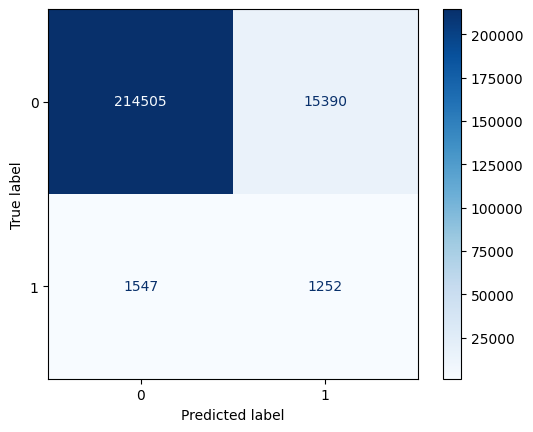

In [48]:
confusion_matrix = confusion_matrix(y_test, y_pred_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot(cmap="Blues")

plt.show()



### Random Forest Classifier

In [49]:
"""
# Forcer l'exécution sur CPU
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
# Nombre d'arbres de ta forêt
n_estimators = 300

# Créer un modèle en mode "warm_start" (permet d’ajouter les arbres un par un)
with tf.device("/CPU:0"):
    rf = RandomForestClassifier(
        n_estimators=1,  # on commence avec 1 arbre
        warm_start=True,
        random_state=42
    )

    # Entraînement incrémental avec tqdm
    for i in tqdm(range(1, n_estimators + 1), desc="Entraînement RF"):
        rf.n_estimators = i
        rf.fit(X_train_df, y_train)
"""

'\n# Forcer l\'exécution sur CPU\nfrom sklearn.ensemble import RandomForestClassifier\nfrom tqdm import tqdm\n# Nombre d\'arbres de ta forêt\nn_estimators = 300\n\n# Créer un modèle en mode "warm_start" (permet d’ajouter les arbres un par un)\nwith tf.device("/CPU:0"):\n    rf = RandomForestClassifier(\n        n_estimators=1,  # on commence avec 1 arbre\n        warm_start=True,\n        random_state=42\n    )\n\n    # Entraînement incrémental avec tqdm\n    for i in tqdm(range(1, n_estimators + 1), desc="Entraînement RF"):\n        rf.n_estimators = i\n        rf.fit(X_train_df, y_train)\n'

In [50]:
"""
# Importance des features
importance_rf = rf.feature_importances_

# Afficher les résultats
feature_importance_rf = pd.DataFrame({
    'Feature': X_train_df.columns,
    'Importance': importance_rf
}).sort_values(by='Importance', ascending=False)

feature_importance_rf
"""

"\n# Importance des features\nimportance_rf = rf.feature_importances_\n\n# Afficher les résultats\nfeature_importance_rf = pd.DataFrame({\n    'Feature': X_train_df.columns,\n    'Importance': importance_rf\n}).sort_values(by='Importance', ascending=False)\n\nfeature_importance_rf\n"

In [51]:
"""
# Visualiser l'importance des features
plt.figure(figsize=(20, 20))
plt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], color='skyblue')
plt.xlabel('Importance des Features')
plt.title('Importance des Features dans le Modèle Random Forest')
plt.show()
"""

"\n# Visualiser l'importance des features\nplt.figure(figsize=(20, 20))\nplt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], color='skyblue')\nplt.xlabel('Importance des Features')\nplt.title('Importance des Features dans le Modèle Random Forest')\nplt.show()\n"

### PCA

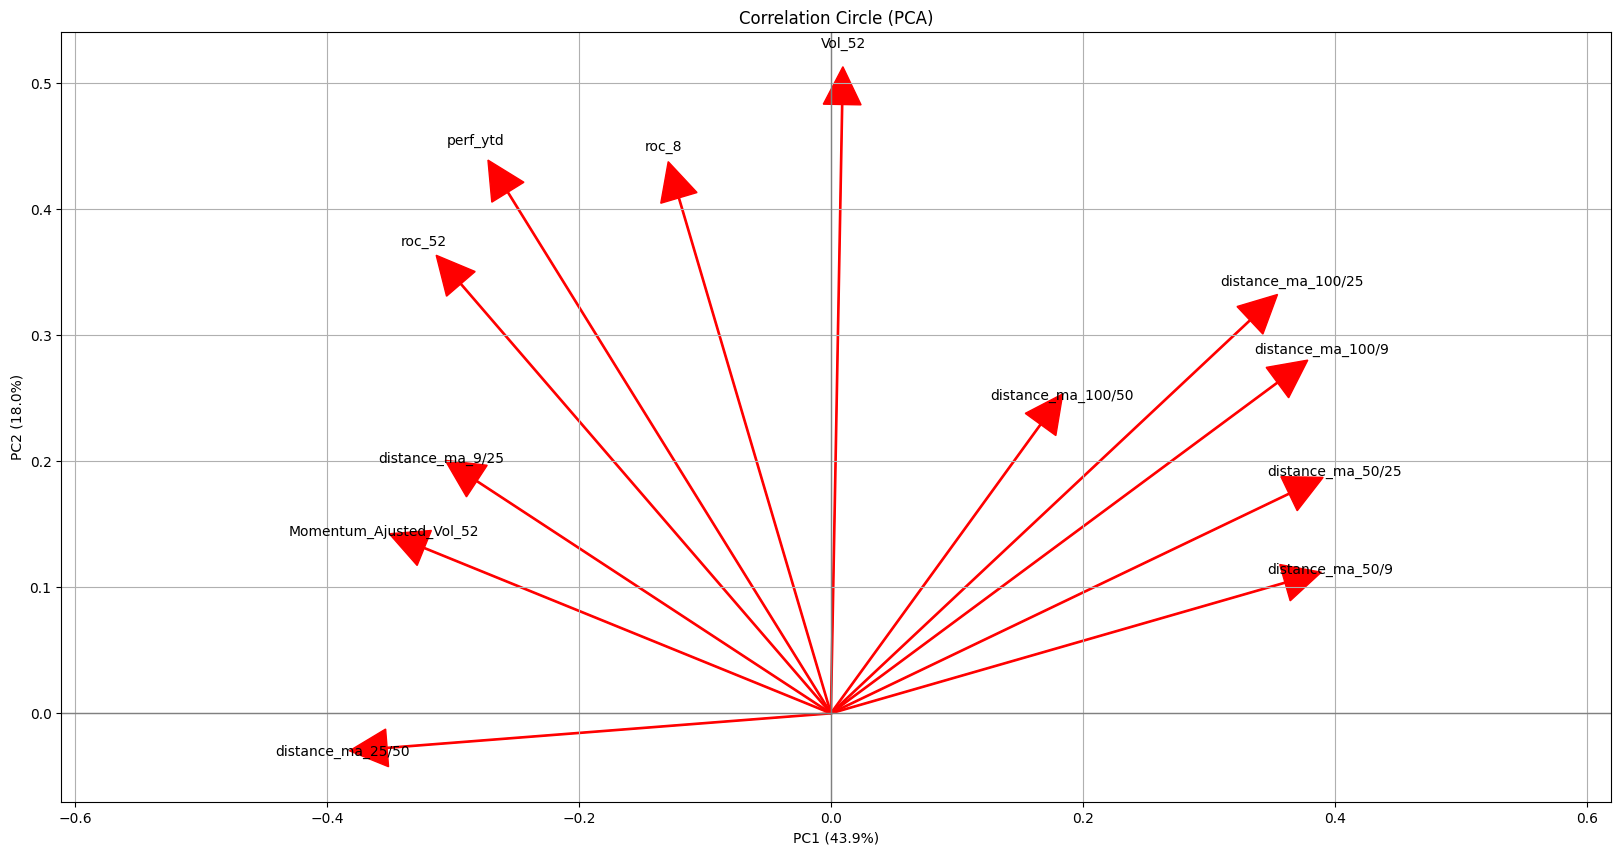

In [52]:

from sklearn.decomposition import PCA

#scaler = StandardScaler()
#X_res = scaler.fit_transform(X_res)

# Apply PCA
pca = PCA(n_components=len(feature_cols))
X_pca = pca.fit_transform(X_train_scale)

# Get the components (loadings)
pcs = pca.components_

# Get the feature names
features =feature_cols

# Correlation circle
plt.figure(figsize=(20, 10))
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)

# Draw unit circle
circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Plot arrows for each feature
for i, feature in enumerate(features):
    plt.arrow(0, 0, pcs[0, i], pcs[1, i], head_width=0.03, head_length=0.03, color='r')
    plt.text(pcs[0, i]*1.1, pcs[1, i]*1.1, feature, color='black', ha='center', va='center')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Correlation Circle (PCA)")
plt.grid()
plt.axis('equal')
plt.show()

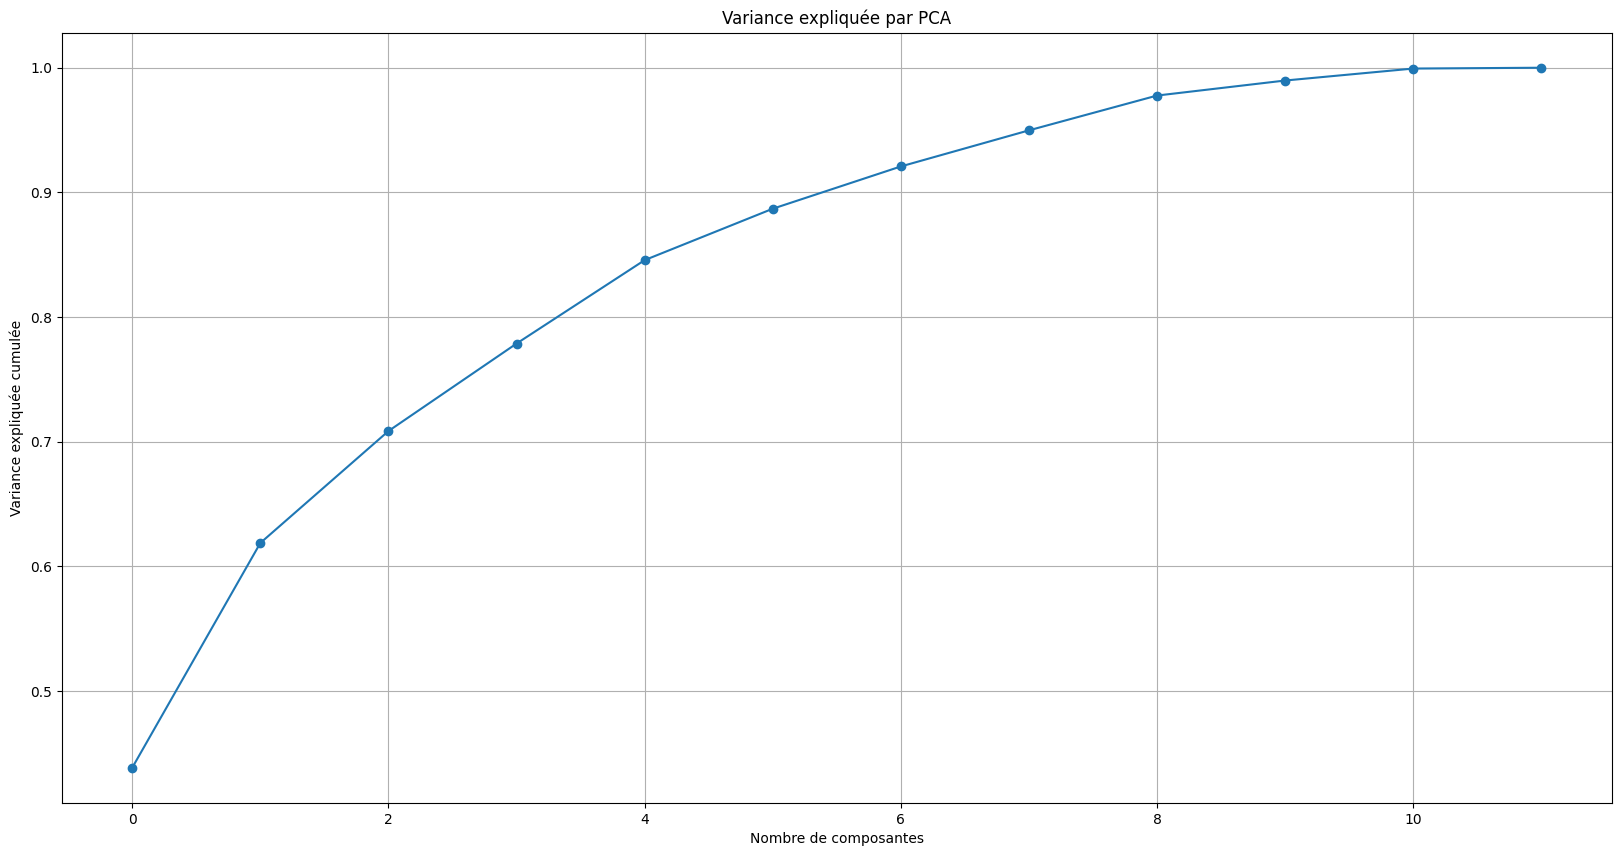

In [53]:

pca = PCA()
pca.fit(X_train_scale)  # X doit être centré-réduit !

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(20, 10))
plt.plot(cumulative_var, marker='o')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance expliquée cumulée")
plt.title("Variance expliquée par PCA")
plt.grid()
plt.show()


### Courbe ROC - AUC

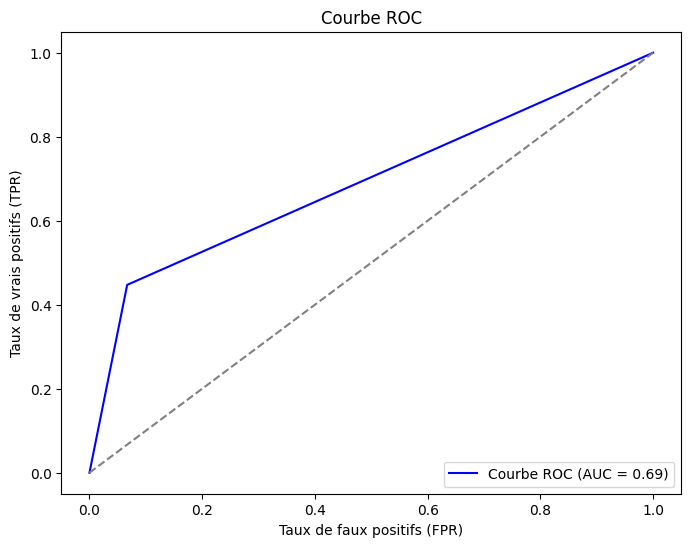

In [54]:
# Calcul des valeurs pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Calcul de l'AUC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne de référence (modèle aléatoire)
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

# Total Return Model Past Data

### Initialisation

In [55]:
def Calculate_Alpha_Jensen(portfolio_returns: pd.Series,
                          benchmark_returns: pd.Series,
                          risk_free_rate: float = 0.2
                         ) -> float:

    # 2) Estimation de beta
    cov_pm = np.cov(portfolio_returns, benchmark_returns, ddof=0)[0, 0]
    var_m  = np.var(benchmark_returns, ddof=0)
    beta   = cov_pm / var_m

    # 3) Rendement moyen
    mean_port = np.mean(portfolio_returns)
    mean_bench = np.mean(benchmark_returns)

    # 4) Calcul de l'alpha
    expected_port = risk_free_rate + beta * (mean_bench - risk_free_rate)
    alpha = mean_port - expected_port

    return alpha

In [56]:
def Calculate_CAGR(portfolio_returns, annual_returns):

    # Paramètres
    V_fin = portfolio_returns.iloc[-1]
    V_debut = initiale_capital
    t = annual_returns

    # Calculer du CAGR
    CAGR = (((V_fin / V_debut) ** (1 / t)) -1) * 100

    return CAGR

In [57]:
def Calculate_Volatility(returns, periods_per_year = 12):

    vol = returns.std(ddof=1)
    vol *= np.sqrt(periods_per_year)

    return vol

In [58]:
def Calculate_Sharpe_Ratio(returns, vol, risk_free_rate=0.02, periods_per_year=12):

    returns = Calculate_CAGR(returns, len(returns))
    excess_returns = returns - (risk_free_rate / periods_per_year)
    mean_exc = excess_returns.mean() * periods_per_year

    return mean_exc / Calculate_Volatility(vol)

In [59]:
def Calculate_Total_Returns(portfolio_returns):

    Value_start = initiale_capital
    Value_final = portfolio_returns.iloc[-1]

    Total_Returns = (Value_final - Value_start) / Value_start

    return Total_Returns

In [60]:
def Calculate_Max_Drawdown(annual_returns):

    maxdrawdown = annual_returns.min()

    return maxdrawdown

In [811]:
daily_data = pd.DataFrame()
data_SP500 = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_SP500.parquet')
data_NDX = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_NASDAQ.parquet')
data_MP = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_MP.parquet')
data_Crypto = pd.read_parquet('/Users/forget/Library/Mobile Documents/com~apple~CloudDocs/Project Stock Market Deep Learning/Data/data_Crypto.parquet')
daily_data = pd.concat([data_SP500, data_NDX, data_MP, data_Crypto], ignore_index=True)
daily_data = daily_data.drop_duplicates(subset=['Ticker', 'Date'])

daily_data = daily_data.drop(columns=['Adj Close'])
# trier la data pour préparer la fusion
daily_data = daily_data.sort_values(by=['Date'], ascending=[True])

#Date au format Date
daily_data['Date'] = pd.to_datetime(daily_data['Date'])

# Définir la colonne 'Date' comme index
daily_data.set_index('Date', inplace=True)
daily_data

Price               Close           High            Low           Open  \
Date                                                                     
1976-07-01       0.440307       0.455666       0.440307       0.440307   
1976-07-01       0.159507       0.159507       0.157715       0.157715   
1976-07-01       0.109001       0.112029       0.109001       0.109001   
1976-07-01       0.205049       0.206582       0.203823       0.206275   
1976-07-01       0.865298       0.871009       0.862442       0.868154   
...                   ...            ...            ...            ...   
2025-09-15      63.130001      63.240002      62.520000      62.970001   
2025-09-15      42.674999      42.840000      42.500000      42.724998   
2025-09-15    3679.500000    3684.300049    3662.800049    3680.199951   
2025-09-15  116292.226562  116728.804688  114914.414062  115377.843750   
2025-09-15       0.275676       0.281553       0.275296       0.278554   

Price             Volume    Ticker  
Date                                
1976-07-01  2.824000e+05       BAC  
1976-07-01  7.040000e+04      BALL  
1976-07-01  2.073600e+06       MDT  
1976-07-01  1.939200e+06        KO  
1976-07-01  9.496000e+05       CVX  
...                  ...       ...  
2025-09-15  9.724000e+03      CL=F  
2025-09-15  8.619000e+03      SI=F  
2025-09-15  3.597300e+04      GC=F  
2025-09-15  3.610513e+10   BTC-USD  
2025-09-15  5.066902e+09  DOGE-USD  

[3912338 rows x 6 columns]

In [812]:
weekly_data = daily_data.groupby("Ticker").resample('W').agg({
    'Open': 'first',   # Premier prix d'ouverture du mois
    'High': 'max',     # Plus haut du mois
    'Low': 'min',      # Plus bas du mois
    'Close': 'last',   # Dernier prix de clôture du mois
    'Volume': 'sum',   # Somme du volume sur le mois
}).reset_index()

In [813]:
# Calculer le rendement pour chaque Ticker avec un décalage d'un mois
weekly_data['Return'] = (weekly_data['Close'] / weekly_data['Open']) -1

# Paramètres
liste_ma = [9, 20, 25, 50, 100]

# Calcul des moyennes mobiles pour chaque fenêtre
for window in liste_ma:
    # Calcul de la moyenne mobile pour chaque 'Ticker'
    ma_column = f'ma_{window}'
    weekly_data[ma_column] = weekly_data.groupby('Ticker')['Close'].transform(lambda s: s.rolling(window, min_periods=1).mean())

liste_ma_1 = [9, 25, 50, 100]
liste_ma_2 = [9, 25, 50, 100]

for window in liste_ma_1:
    for window_2 in liste_ma_2:

        # Calcul de la moyenne mobile pour chaque 'Ticker'
        ma_column_1 = f'ma_{window}'
        ma_column_2 = f'ma_{window_2}'
        distance_ma_column = f'distance_ma_{window_2}/{window}'

        if ma_column_1 != ma_column_2:
            # Calcul du pourcentage d'écart entre le prix et la moyenne mobile
            weekly_data[distance_ma_column] = weekly_data[ma_column_2] / weekly_data[ma_column_1]


list_window = [4, 8, 12, 26, 52] # Liste de valeurs de top_n pour la sélection des meilleurs

# Calcul des performances pour chaque fenêtre
for window in list_window:

    # Nom dynamique de la colonne pour la performance
    roc_column = f'roc_{window}'

    # Calcul de la performance pour chaque 'Ticker' sur la fenêtre spécifiée
    weekly_data[roc_column] = weekly_data.groupby('Ticker')['Close'].pct_change(window)

liste_ma = [9, 25]
for window in liste_ma:

    # Calcul de la moyenne mobile pour chaque 'Ticker'
    distance_price_column = f'distance_price_{window}'
    ma_column = f'ma_{window}'

    # Calcul du pourcentage d'écart entre le prix et la moyenne mobile
    weekly_data[distance_price_column] = weekly_data['Close'] / weekly_data[ma_column]

weekly_data['Year'] = weekly_data['Date'].dt.year

# Close d’ancrage (première observation de l'année par Ticker)
anchor_close = weekly_data.groupby(['Ticker','Year'])['Close'].transform('first')

# Perf YTD (depuis le début d’année)
weekly_data['perf_ytd'] = weekly_data['Close'] / anchor_close - 1

list_window = [4, 8, 12, 26, 52] # Liste de valeurs de top_n pour la sélection des meilleurs

# Calcul des performances pour chaque fenêtre
for window in list_window:

    # Nom dynamique de la colonne pour la performance
    MAV_column = f'Momentum_Ajusted_Vol_{window}'
    Perf_column = f'Perf_{window}'
    Vol_column = f'Vol_{window}'

    # Calcul de la performance pour chaque 'Ticker' sur la fenêtre spécifiée
    weekly_data[Perf_column] = weekly_data.groupby('Ticker')['Close'].pct_change(window)
    weekly_data[Vol_column] = weekly_data.groupby('Ticker')['Return'].rolling(window=window).std().reset_index(level=0, drop=True)
    weekly_data[MAV_column] = weekly_data[Perf_column] / weekly_data[Vol_column]

period = 25

# Variation quotidienne
weekly_data['delta'] = weekly_data.groupby('Ticker')['Close'].diff()

# Gains et pertes
weekly_data['gains'] = weekly_data['delta'].clip(lower=0)
weekly_data['losses'] = -weekly_data['delta'].clip(upper=0)

# Moyenne mobile simple sur 'period' jours
weekly_data['avg_gain'] = (
    weekly_data.groupby('Ticker')['gains']
    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())
)
weekly_data['avg_losses'] = (
    weekly_data.groupby('Ticker')['losses']
    .transform(lambda x: x.rolling(window=period, min_periods=period).mean())
)

# RS et RSI
weekly_data['rs'] = weekly_data['avg_gain'] / weekly_data['avg_losses']
weekly_data['rsi'] = 100 - (100 / (1 + weekly_data['rs']))

#weekly_data = weekly_data.drop(columns=['Return', 'ma_9', 'ma_25', 'ma_50', 'ma_100'])
weekly_data = weekly_data.dropna()

/var/folders/6k/82j2nnl13hj9ld7nmzpdt6fh0000gn/T/ipykernel_1137/3999834889.py:38: FutureWarning:

The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/var/folders/6k/82j2nnl13hj9ld7nmzpdt6fh0000gn/T/ipykernel_1137/3999834889.py:38: FutureWarning:

The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

/var/folders/6k/82j2nnl13hj9ld7nmzpdt6fh0000gn/T/ipykernel_1137/3999834889.py:38: FutureWarning:

The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA v

In [814]:
start_date = "1990-01-01"
end_date = "2025-09-12"
daily_data = daily_data.reset_index()
daily_data = daily_data[daily_data['Date'] >= start_date]
weekly_data = weekly_data[weekly_data['Date'] >= start_date]

daily_data = daily_data[daily_data['Date'] <= end_date]
weekly_data = weekly_data[weekly_data['Date'] <= end_date]

weekly_data = weekly_data.replace([np.inf, -np.inf], 0)
#weekly_data = weekly_data.drop(columns=['Close', 'Open', 'High', 'Low', 'Volume'])
# Remplacer les valeurs NaN par 0
weekly_data = weekly_data.dropna()

weekly_data

Price  Ticker       Date        Open        High         Low       Close  \
52          A 2000-11-19   23.512443   28.499929   22.837444   28.424927   
53          A 2000-11-26   28.124937   30.899933   26.287439   30.562435   
54          A 2000-12-03   30.562427   32.812430   29.999928   31.799932   
55          A 2000-12-10   31.237410   35.924906   30.299913   35.662407   
56          A 2000-12-17   35.174919   35.812417   32.699926   34.124924   
...       ...        ...         ...         ...         ...         ...   
809571    ZTS 2025-08-10  151.250000  160.050003  144.250000  147.350006   
809572    ZTS 2025-08-17  147.669998  155.100006  147.350006  154.110001   
809573    ZTS 2025-08-24  154.000000  160.479996  151.600006  156.619995   
809574    ZTS 2025-08-31  156.759995  157.210007  153.289993  156.399994   
809575    ZTS 2025-09-07  154.979996  155.380005  151.350006  153.320007   

Price       Volume    Return        ma_9       ma_20  ...   Perf_52    Vol_52  \
52      22982282.0  0.208931   28.095763   30.869924  ...  0.173375  0.160231   
53      19656719.0  0.086667   28.158262   30.373050  ...  0.236723  0.160547   
54      19512026.0  0.040491   28.429097   29.651178  ...  0.191012  0.160276   
55      20204315.0  0.141657   28.912430   29.992427  ...  0.328212  0.161222   
56      19708864.0 -0.029851   29.745762   30.461177  ...  0.238095  0.161345   
...            ...       ...         ...         ...  ...       ...       ...   
809571  24442400.0 -0.025785  153.846795  156.214131  ... -0.194911  0.028454   
809572  15245700.0  0.043611  152.772090  155.818647  ... -0.150918  0.029191   
809573  12640900.0  0.017013  152.769179  156.113860  ... -0.123685  0.029255   
809574  10709200.0 -0.002297  152.852563  156.511806  ... -0.137268  0.029173   
809575   7327400.0 -0.010711  152.260398  156.793997  ... -0.179912  0.028696   

Price   Momentum_Ajusted_Vol_52     delta     gains    losses  avg_gain  \
52                     1.082027  4.762493  4.762493 -0.000000  1.801493   
53                     1.474477  2.137508  2.137508 -0.000000  1.484995   
54                     1.191771  1.237497  1.237497 -0.000000  1.534495   
55                     2.035779  3.862474  3.862474 -0.000000  1.688994   
56                     1.475689 -1.537483  0.000000  1.537483  1.388995   
...                         ...       ...       ...       ...       ...   
809571                -6.849939 -0.029999  0.000000  0.029999  1.739874   
809572                -5.169934  6.759995  6.759995 -0.000000  1.893459   
809573                -4.227880  2.509995  2.509995 -0.000000  1.724473   
809574                -4.705350 -0.220001  0.000000  0.220001  1.600110   
809575                -6.269657 -3.079987  0.000000  3.079987  1.600110   

Price   avg_losses        rs        rsi  
52        2.224493  0.809845  44.746636  
53        2.224493  0.667566  40.032350  
54        1.963494  0.781513  43.867922  
55        1.765494  0.956669  48.892746  
56        1.826993  0.760263  43.190305  
...            ...       ...        ...  
809571    2.104556  0.826718  45.257007  
809572    2.104556  0.899696  47.359988  
809573    2.104556  0.819400  45.036822  
809574    2.113356  0.757142  43.089395  
809575    1.874591  0.853578  46.050290  

[689745 rows x 56 columns]

In [815]:

# 1) Télécharger les cours mensuels ajustés du S&P 500
ndx = yf.download(
    "^GSPC",
    start="1976-07-01",
    end="2025-07-17",
    interval="1wk",
    auto_adjust=True,
    actions=False
)[["Open", "Close"]]

ndx.columns = ndx.columns.droplevel(level=1)

ndx.columns = ['ndx_Open', 'ndx_Close']

# 2) Convertir l’index en période mensuelle, puis au TIMESTAMP de fin de mois
ndx.index = pd.to_datetime(ndx.index)

# 3) Normaliser pour que le S&P 500 commence à la même valeur que le capital initial
ndx['Return'] = (ndx['ndx_Close'].pct_change()).fillna(0)

# Calcul des moyennes mobiles pour chaque fenêtre
ndx['Slow_ma'] = ndx['ndx_Close'].rolling(window=50, min_periods=1).mean()
ndx['Fast_ma'] = ndx['ndx_Close'].rolling(window=25, min_periods=1).mean()

crisis = []
for i in range(0, len(ndx)):
    if ndx['Slow_ma'].iloc[i] < ndx['ndx_Close'].iloc[i] and ndx['Slow_ma'].iloc[i] < ndx['ndx_Open'].iloc[i] and ndx['Slow_ma'].iloc[i] < ndx['Fast_ma'].iloc[i]:
        crisis.append(0)
    elif ndx['Fast_ma'].iloc[i] < ndx['ndx_Close'].iloc[i] and ndx['Fast_ma'].iloc[i] < ndx['ndx_Open'].iloc[i] and ndx['Slow_ma'].iloc[i] > ndx['Fast_ma'].iloc[i]:
        crisis.append(0)
    else:
        crisis.append(1)

ndx['Crisis'] = crisis

ndx = ndx.fillna(0)
ndx = ndx.drop(columns=['ndx_Open', 'ndx_Close','Return', 'Slow_ma', 'Fast_ma'])

weekly_data = pd.merge_asof(
    weekly_data.sort_values('Date'),
    ndx.sort_values('Date'),
    on='Date',
    direction='backward'
)

#data = data[data['Crisis'] == 0]


[*********************100%***********************]  1 of 1 completed


In [816]:
#data = data.drop(columns=['distance_ma_25/9', 'distance_ma_50/9', 'distance_ma_100/9', 'distance_ma_25/50', 'distance_ma_50/100', 'distance_ma_25/100'])

In [817]:
feature_cols

['distance_ma_50/9',
 'distance_ma_100/9',
 'distance_ma_9/25',
 'distance_ma_50/25',
 'distance_ma_100/25',
 'distance_ma_25/50',
 'distance_ma_100/50',
 'roc_8',
 'roc_52',
 'Vol_52',
 'Momentum_Ajusted_Vol_52',
 'perf_ytd']

In [818]:
X = weekly_data[[
'distance_ma_50/9',
 'distance_ma_100/9',
 'distance_ma_9/25',
 'distance_ma_50/25',
 'distance_ma_100/25',
 'distance_ma_25/50',
 'distance_ma_100/50',
 'roc_8',
 'roc_52',
 'Vol_52',
 'Momentum_Ajusted_Vol_52',
 'perf_ytd']]

X_scale_test = scaler.fit_transform(X)
weekly_data['Proba'] = best_model.predict(X_scale_test).ravel()


21555/21555 ━━━━━━━━━━━━━━━━━━━━ 6s 288us/step


In [819]:
weekly_data['Prediction'] = (weekly_data['Proba'] > 0.5).astype(int)
weekly_data['Prediction'].value_counts()

Prediction
0    633708
1     56037
Name: count, dtype: int64

### Backtest

In [820]:
daily_data['Return'] = daily_data.groupby('Ticker')['Close'].pct_change()
daily_data = daily_data[['Date', 'Close', 'Open', 'Ticker', 'Return']]
weekly_data = weekly_data.drop(columns=['Close', 'Open', 'Return'])


In [821]:
daily_data

Price         Date       Close        Open Ticker    Return
493199  1990-01-02    5.347508    5.374113    TSN       NaN
493200  1990-01-02    5.893526    5.811163    MMM       NaN
493201  1990-01-02    0.370648    0.361824    RJF       NaN
493202  1990-01-02    2.070625    2.061543    ETN       NaN
493203  1990-01-02    3.341974    3.174876    LHX       NaN
...            ...         ...         ...    ...       ...
3912306 2025-09-12   66.529999   66.879997   CSCO -0.017137
3912307 2025-09-12  755.390015  760.169983    LLY -0.001177
3912308 2025-09-12  436.100006  435.390015   CRWD  0.006276
3912309 2025-09-12  242.759995  246.100006    CRM -0.014293
3912310 2025-09-12  130.649994  133.630005   STLD -0.024927

[3419112 rows x 5 columns]

In [822]:
data = pd.merge_asof(daily_data, weekly_data, on='Date', by='Ticker', direction='backward')
data['weekday'] = data['Date'].dt.dayofweek
data = data[data['weekday'] < 5]

In [823]:
import numpy as np
import pandas as pd

def backtest(
    data: pd.DataFrame,
    initial_capital: float = 1000,
    save_month: float = 0,
    fee_per_trade: float = 0,
    moving_average_buy: int = 9,
    moving_average_sell: int = 25,
    proba_column: str = "Proba",
    max_positions: int = 10,
    leverage: float = 1.0,
    weight: float = 1.0,
):
    """
    Backtest vectorisé avec pandas :
      - data : DataFrame (Date, Ticker, Open, Close, Prediction, Return, Crisis, ma_xx, Proba, ...)
      - stop_loss : seuil de perte à partir du prix d’entrée (optionnel)
      - retourne aussi la liste des tickers détenus par jour
    """

    ma_buy  = f"ma_{moving_average_buy}"
    ma_sell = f"ma_{moving_average_sell}"

    required = ["Date","Ticker","Open","Close","Prediction","Return",ma_buy,ma_sell,"Crisis", 'rsi']
    missing = [c for c in required if c not in data.columns]
    if (missing or max_positions >weight):
        raise ValueError(f"Colonnes manquantes: {missing}")

    df = data.sort_values(["Date", "Ticker"]).copy()

    # --- 1. Préparer signaux (vectorisé) ---
    df["BuySignal"] = (
        (df[ma_buy] < df["Open"]) &
        (df[ma_buy] < df["Close"]) &
        (df["Prediction"] == 1) &
        (df['rsi'] > 55)
    )

    df["SellSignal"] = (
        (df[ma_sell] > df["Open"]) &
        (df[ma_sell] > df["Close"])
    ) | (df["rsi"] < 55)

    # Poids (score de tri pour sélectionner max_positions)
    if proba_column in df.columns:
        df["Score"] = df[proba_column].fillna(0.0)
    else:
        df["Score"] = (df["Close"] / df[ma_buy] - 1.0).replace([np.inf, -np.inf], np.nan).fillna(0.0)

    # Décalage Return pour obtenir rendement t+1 directement
    df["NextReturn"] = df.groupby("Ticker")["Return"].shift(-1)

    # --- 2. Boucle sur dates (plus légère) ---
    unique_dates = df["Date"].drop_duplicates().sort_values().to_numpy()
    capital = initial_capital

    portfolio_values, returns, n_positions, fees_hist, mean_return_history = [], [], [], [], []
    tickers_history = {}  # 🔥 tickers détenus par jour

    prev_holdings = set()

    for date in unique_dates:
        day = df.loc[df["Date"] == date]

        # Ajouter capital mensuel
        capital += save_month

        # Gestion des signaux
        buy_set  = set(day.loc[day["BuySignal"], "Ticker"])
        sell_set = set(day.loc[day["SellSignal"], "Ticker"])

        # Portefeuille courant
        held_after_sell = prev_holdings - sell_set
        new_buys = buy_set - prev_holdings

        # Tri par Score
        scores = day.set_index("Ticker")["Score"].to_dict()
        held_sorted = sorted(list(held_after_sell), key=lambda t: scores.get(t, 0.0), reverse=True)

        if len(held_sorted) >= max_positions:
            current_portfolio = set(held_sorted[:max_positions])
        else:
            remaining = max_positions - len(held_sorted)
            new_sorted = sorted(list(new_buys), key=lambda t: scores.get(t, 0.0), reverse=True)
            add_these = new_sorted[:remaining]
            current_portfolio = set(held_sorted + add_these)

        # Frais
        opened = current_portfolio - prev_holdings
        closed = prev_holdings - current_portfolio
        trades = len(opened) + len(closed)
        fees = trades * fee_per_trade
        capital -= fees

        # Calcul rendement t+1
        r = day.loc[day["Ticker"].isin(current_portfolio), "NextReturn"].dropna().to_numpy()
        l = day.loc[day["Ticker"].isin(current_portfolio), ("NextReturn", 'Ticker')]
        if r.size > 0:
            mean_return = np.mean(r) * leverage
            invested_fraction = len(r) / weight  # part du capital investi
            capital *= 1 + invested_fraction * mean_return
        else:
            mean_return = 0.0
            capital *= (1 + mean_return)

        # Historique
        portfolio_values.append(capital)
        returns.append(mean_return)
        n_positions.append(len(current_portfolio))
        fees_hist.append(fees)
        tickers_history[date] = l # 🔥 tickers détenus
        mean_return_history.append(mean_return)

        prev_holdings = current_portfolio

    # --- Résultats ---
    portfolio_per_day = pd.DataFrame({
        "Date": unique_dates,
        "Capital": portfolio_values,
        "Return": np.array(returns) * 100.0,
        "Ticker_Count": n_positions,
        "Fees": fees_hist,
        "Return_Mean": mean_return_history,
    }).set_index("Date")

    monthly = portfolio_per_day.resample("ME").agg({
        "Capital": "last",
        "Ticker_Count": "mean",
        "Fees": "sum",
        "Return_Mean": "mean",
    })
    first_cap_m = portfolio_per_day["Capital"].resample("ME").first().ffill()
    last_cap_m  = portfolio_per_day["Capital"].resample("ME").last().ffill()
    monthly["Return"] = ((last_cap_m / first_cap_m - 1.0) * 100.0).fillna(0.0)

    annual = portfolio_per_day.resample("YE").agg({
        "Capital": "last",
        "Ticker_Count": "mean",
        "Fees": "sum",
        "Return_Mean": "mean"
    })
    first_cap_y = portfolio_per_day["Capital"].resample("YE").first().ffill()
    last_cap_y  = portfolio_per_day["Capital"].resample("YE").last().ffill()
    annual["Return"] = ((last_cap_y / first_cap_y - 1.0) * 100.0).fillna(0.0)

    return portfolio_per_day, monthly, annual, tickers_history

In [905]:
initiale_capital = 1000
portfolio_per_day, portfolio_per_month, portfolio_per_annual, list_ticker = backtest(data, initial_capital=initiale_capital, save_month=0, fee_per_trade=1, moving_average_buy=9, moving_average_sell=9, max_positions=10, leverage=3, weight=15)

In [906]:
worst = portfolio_per_month[portfolio_per_month['Return'] < 0]
worst = worst.sort_values(by=['Return'], ascending=True)
print(len(portfolio_per_month), len(worst), len(worst)/len(portfolio_per_month)*100)
worst.head(20)

429 176 41.02564102564102


Capital  Ticker_Count  Fees  Return_Mean     Return
Date                                                                
2000-03-31  3.047364e+05     10.000000    16    -0.031046 -38.980955
2012-05-31  1.776260e+07      8.636364    28    -0.023386 -32.889480
2001-01-31  2.121186e+05     10.000000    34    -0.025577 -31.852281
2022-06-30  6.796266e+09      5.454545    18    -0.033024 -30.270821
2025-02-28  2.103940e+10      8.950000    30    -0.023173 -29.078015
2024-04-30  1.936935e+10      9.863636    26    -0.020811 -25.044993
1999-02-28  5.387489e+04     10.000000    14    -0.024680 -25.041111
2003-01-31  1.108000e+05      8.904762    31    -0.016036 -24.392643
2024-07-31  1.493758e+10      9.869565    32    -0.014544 -23.661261
2001-07-31  2.286008e+05     10.000000    24    -0.017941 -23.618074
2024-12-31  2.610073e+10     10.000000    16    -0.018572 -23.342469
1999-04-30  5.996300e+04     10.000000    16    -0.006881 -22.756518
2018-10-31  2.870807e+08      4.347826    20    -0.030367 -22.655156
2001-09-30  1.476889e+05      4.294118    27    -0.026621 -22.326822
2010-05-31  1.800853e+07      9.550000    42    -0.023569 -22.228392
2006-07-31  1.001785e+07      5.250000    18    -0.030886 -19.606915
2010-06-30  1.509467e+07      9.090909    27    -0.008309 -19.246751
1998-08-31  2.964017e+04      7.571429    18    -0.016216 -19.103784
2022-12-31  7.023399e+09      8.500000    20    -0.012902 -18.690491
1994-03-31  5.137961e+03      9.000000    16    -0.016651 -18.567858

In [907]:
worst_mean_return = portfolio_per_month[portfolio_per_month['Return_Mean'] < 0][['Ticker_Count', 'Fees', 'Return_Mean']]
worst_mean_return = worst_mean_return.sort_values(by=['Return_Mean'], ascending=True)
print(len(portfolio_per_month), len(worst_mean_return), len(worst_mean_return)/len(portfolio_per_month)*100)
worst_mean_return.describe()

429 152 35.43123543123543


Ticker_Count        Fees  Return_Mean
count    152.000000  152.000000   152.000000
mean       7.457901   16.960526    -0.010068
std        2.881701    8.467219     0.008845
min        0.434783    3.000000    -0.040900
25%        4.842650   11.000000    -0.013394
50%        8.976190   16.000000    -0.007074
75%       10.000000   21.250000    -0.003897
max       10.000000   54.000000    -0.000096

In [908]:
best_mean_return = portfolio_per_month[portfolio_per_month['Return_Mean'] > 0]
best_mean_return = best_mean_return.sort_values(by=['Return_Mean'], ascending=False)
print(len(portfolio_per_month), len(best_mean_return), len(best_mean_return)/len(portfolio_per_month)*100)
best_mean_return.describe()

429 277 64.56876456876456


Capital  Ticker_Count        Fees  Return_Mean      Return
count  2.770000e+02    277.000000  277.000000   277.000000  277.000000
mean   1.849080e+09      8.576952    9.732852     0.012545   14.145368
std    5.495143e+09      2.303552    5.504356     0.010606   17.894381
min    7.079973e+02      0.500000    0.000000     0.000043  -12.749420
25%    7.196675e+04      8.136364    6.000000     0.006251    4.310894
50%    1.475979e+07      9.956522   10.000000     0.010097   10.013373
75%    1.146074e+08     10.000000   12.000000     0.016283   18.264724
max    3.266671e+10     10.000000   28.000000     0.074893  143.888486

In [909]:
a = portfolio_per_day[(portfolio_per_day.index <="2008-12-30") & (portfolio_per_day.index >= "2008-12-01")]
a

Capital     Return  Ticker_Count  Fees  Return_Mean
Date                                                                
2008-12-01  8.627810e+06  -7.590083             1     1    -0.075901
2008-12-02  8.734131e+06  18.484541             1     0     0.184845
2008-12-03  8.716874e+06  -2.963713             1     0    -0.029637
2008-12-04  8.812979e+06  16.537812             1     0     0.165378
2008-12-05  8.732142e+06 -13.758882             1     0    -0.137589
2008-12-08  8.465177e+06 -15.286231             3     2    -0.152862
2008-12-09  8.506645e+06   2.449351             3     0     0.024494
2008-12-10  8.336580e+06 -14.993954             2     1    -0.149940
2008-12-11  8.455818e+06  10.727257             2     0     0.107273
2008-12-12  8.448306e+06  -0.666276             2     0    -0.006663
2008-12-15  8.603052e+06  13.737576             2     0     0.137376
2008-12-16  8.624291e+06   1.851568             2     0     0.018516
2008-12-17  8.609694e+06  -1.269357             2     0    -0.012694
2008-12-18  8.555579e+06  -4.714068             2     0    -0.047141
2008-12-19  8.454842e+06  -8.830761             2     0    -0.088308
2008-12-22  8.415928e+06  -3.451950             2     0    -0.034520
2008-12-23  8.443827e+06   2.486294             2     0     0.024863
2008-12-24  8.490569e+06   4.151668             2     0     0.041517
2008-12-26  8.470378e+06  -1.783462             2     0    -0.017835
2008-12-29  8.497790e+06   2.427144             2     0     0.024271
2008-12-30  8.617632e+06  10.577044             2     0     0.105770

In [910]:
portfolio_per_day['Ticker_Count'].describe()

count    9102.000000
mean        8.176005
std         2.798355
min         0.000000
25%         7.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: Ticker_Count, dtype: float64

In [911]:
portfolio_per_month.tail(20)

Capital  Ticker_Count  Fees  Return_Mean     Return
Date                                                                
2024-02-29  2.369068e+10     10.000000     6     0.031073  42.039224
2024-03-31  2.714905e+10     10.000000     2     0.004845   7.680793
2024-04-30  1.936935e+10      9.863636    26    -0.020811 -25.044993
2024-05-31  2.355606e+10      9.913043     8     0.013622  17.219765
2024-06-30  1.947952e+10     10.000000    24    -0.015083 -16.974197
2024-07-31  1.493758e+10      9.869565    32    -0.014544 -23.661261
2024-08-31  1.269338e+10      7.227273    18    -0.006938  -7.317902
2024-09-30  1.615265e+10      8.714286    10     0.021634  27.252568
2024-10-31  1.747101e+10     10.000000     8     0.005577   6.695449
2024-11-30  3.266671e+10     10.000000     6     0.055170  95.888876
2024-12-31  2.610073e+10     10.000000    16    -0.018572 -23.342469
2025-01-31  2.816760e+10      9.913043    18     0.015511   6.642540
2025-02-28  2.103940e+10      8.950000    30    -0.023173 -29.078015
2025-03-31  1.907225e+10      3.047619    15    -0.022685  -8.896510
2025-04-30  2.051638e+10      2.454545     9     0.009123   7.008534
2025-05-31  2.274099e+10      5.636364    12     0.013735   5.867018
2025-06-30  2.315618e+10      9.523810    12     0.001530  -0.137379
2025-07-31  2.460666e+10     10.000000    16     0.004587   5.057292
2025-08-31  2.324832e+10     10.000000    26    -0.003146  -8.879317
2025-09-30  2.833471e+10     10.000000     4     0.030860  21.817020

In [912]:
portfolio_per_annual

Capital  Ticker_Count  Fees  Return_Mean      Return
Date                                                                 
1990-12-31  7.711729e+02      4.320158   100    -0.001911  -22.882709
1991-12-31  3.449571e+03      9.399209   124     0.011691  358.543332
1992-12-31  3.107505e+03      7.720472   156     0.000191  -10.770884
1993-12-31  5.148289e+03      9.806324   158     0.004329   65.271328
1994-12-31  5.840573e+03      6.865079   142     0.004095   15.128114
1995-12-31  1.898816e+04      9.301587   142     0.008553  234.609922
1996-12-31  2.831830e+04      8.409449   174     0.002618   51.378095
1997-12-31  2.422472e+04      8.407115   178     0.000799  -17.974530
1998-12-31  5.303935e+04      8.527778   142     0.006180  120.296970
1999-12-31  2.399833e+05     10.000000   142     0.010892  361.148152
2000-12-31  3.109253e+05      9.988095   210     0.004447   46.845163
2001-12-31  2.117672e+05      9.276000   232    -0.001320  -31.965166
2002-12-31  1.461437e+05      6.948617   187    -0.002990  -32.678515
2003-12-31  1.466829e+06      9.388889   117     0.016690  900.930362
2004-12-31  3.051057e+06      8.444444   142     0.006385   98.769972
2005-12-31  1.044417e+07      8.777778   106     0.009309  262.276935
2006-12-31  1.217011e+07      7.762846   148     0.002153   11.608018
2007-12-31  2.104289e+07      8.415020   120     0.005974   72.906280
2008-12-31  8.733280e+06      4.719368   144    -0.008297  -58.199100
2009-12-31  1.950400e+07      7.996032   128     0.005814  124.240397
2010-12-31  2.509667e+07      9.654762   170     0.003478   25.039601
2011-12-31  2.021168e+07      6.420635   129    -0.002673  -19.018069
2012-12-31  1.877813e+07      8.944000   191     0.001803   -6.766271
2013-12-31  4.065545e+07      9.623016   120     0.005519  118.150769
2014-12-31  6.575885e+07      5.972441    72     0.005897   61.276869
2015-12-31  6.802919e+07      5.670498    90     0.000778    3.452526
2016-12-31  1.146074e+08      6.934866   140     0.004064   68.227000
2017-12-31  2.303322e+08      8.600000   119     0.008342  100.109669
2018-12-31  2.434559e+08      6.816092   120     0.000583    3.686024
2019-12-31  3.609550e+08      8.252874   143     0.005014   48.262962
2020-12-31  1.479209e+09      8.923664   122     0.014810  309.804387
2021-12-31  7.480697e+09      9.934866   190     0.013985  401.545925
2022-12-31  7.023399e+09      7.200000   156     0.001850   -8.262259
2023-12-31  1.432263e+10      9.588462   206     0.005919  103.927272
2024-12-31  2.610073e+10      9.633588   172     0.005004   82.546678
2025-12-31  2.833471e+10      7.590164   142     0.001639    7.275237

In [913]:
list_ticker

{np.datetime64('1990-01-02T00:00:00.000000000'): Empty DataFrame
 Columns: [NextReturn, Ticker]
 Index: [],
 np.datetime64('1990-01-03T00:00:00.000000000'): Empty DataFrame
 Columns: [NextReturn, Ticker]
 Index: [],
 np.datetime64('1990-01-04T00:00:00.000000000'): Empty DataFrame
 Columns: [NextReturn, Ticker]
 Index: [],
 np.datetime64('1990-01-05T00:00:00.000000000'): Empty DataFrame
 Columns: [NextReturn, Ticker]
 Index: [],
 np.datetime64('1990-01-08T00:00:00.000000000'):      NextReturn Ticker
 900   -0.009709    DVN,
 np.datetime64('1990-01-09T00:00:00.000000000'):       NextReturn Ticker
 1055   -0.009804    DVN,
 np.datetime64('1990-01-10T00:00:00.000000000'):       NextReturn Ticker
 1229   -0.009901    DVN,
 np.datetime64('1990-01-11T00:00:00.000000000'): Empty DataFrame
 Columns: [NextReturn, Ticker]
 Index: [],
 np.datetime64('1990-01-12T00:00:00.000000000'): Empty DataFrame
 Columns: [NextReturn, Ticker]
 Index: [],
 np.datetime64('1990-01-15T00:00:00.000000000'): Empty Da

In [914]:
list_ticker.items()

dict_items([(np.datetime64('1990-01-02T00:00:00.000000000'), Empty DataFrame
Columns: [NextReturn, Ticker]
Index: []), (np.datetime64('1990-01-03T00:00:00.000000000'), Empty DataFrame
Columns: [NextReturn, Ticker]
Index: []), (np.datetime64('1990-01-04T00:00:00.000000000'), Empty DataFrame
Columns: [NextReturn, Ticker]
Index: []), (np.datetime64('1990-01-05T00:00:00.000000000'), Empty DataFrame
Columns: [NextReturn, Ticker]
Index: []), (np.datetime64('1990-01-08T00:00:00.000000000'),      NextReturn Ticker
900   -0.009709    DVN), (np.datetime64('1990-01-09T00:00:00.000000000'),       NextReturn Ticker
1055   -0.009804    DVN), (np.datetime64('1990-01-10T00:00:00.000000000'),       NextReturn Ticker
1229   -0.009901    DVN), (np.datetime64('1990-01-11T00:00:00.000000000'), Empty DataFrame
Columns: [NextReturn, Ticker]
Index: []), (np.datetime64('1990-01-12T00:00:00.000000000'), Empty DataFrame
Columns: [NextReturn, Ticker]
Index: []), (np.datetime64('1990-01-15T00:00:00.000000000'), Em

In [915]:
# 1) Calculer le drawdown mensuel
#    drawdown = (Capital / pic_historique) - 1
portfolio_per_day['Peak'] = portfolio_per_day['Capital'].cummax()
portfolio_per_day['Drawdown'] = portfolio_per_day['Capital'] / portfolio_per_day['Peak'] - 1

# 2) Résultat : série mensuelle de drawdowns
#    Le drawdown est négatif (0 au pic, baisse ensuite)  [oai_citation:0‡reddit.com](https://www.reddit.com/r/learnpython/comments/bxyze5/getting_max_drawdown_with_python/?utm_source=chatgpt.com)

# 3) Calculer le max drawdown global
max_dd_global = portfolio_per_day['Drawdown'].min()

# 4) Calculer le drawdown maximal par année
#    On regroupe par année et on prend le minimum (le plus négatif) de Drawdown
mensuel_max_dd = (
    portfolio_per_day['Drawdown']
    .groupby(portfolio_per_day.index.year)
    .min()
    .rename('MaxDrawdown')
    .to_frame()
)

# Calcul du nombre d'actions sélectionnées chaque mois
monthly_counts = data.groupby('Date')['Prediction'].sum()
monthly_counts.index = pd.to_datetime(monthly_counts.index)

# Moyenne des sélections mensuelles
average_count = monthly_counts.mean()

# 1) Regrouper par année (resample('Y') pour Year-End)
annual_counts = monthly_counts.resample('YE').sum()

# 2) Calculer la moyenne annuelle des sélections
average_annual_count = annual_counts.mean()


In [916]:
data = data.sort_values('Date')
# 1) Télécharger les cours mensuels ajustés du S&P 500
ndx = yf.download(
    "^GSPC",
    start=data['Date'].iloc[0],
    end=data['Date'].iloc[-1],
    interval="1d",
    auto_adjust=True,
    actions=False
)["Close"]
# 2) Convertir l’index en période mensuelle, puis au TIMESTAMP de fin de mois
ndx.index = pd.to_datetime(ndx.index)

# 3) Normaliser pour que le S&P 500 commence à la même valeur que le capital initial
ndx_return = (ndx.pct_change())

# 4) Reindexer ndx_norm sur l’index de portfolio_per_month (remplit les mois manquants par propagation)
ndx_return = ndx_return.reindex(portfolio_per_day.index, method="ffill")

# 5) Fusionner dans df_bench
portfolio_per_day["S&P500_return"] = ndx_return
portfolio_per_day["S&P500_return"].fillna(0)

initial_cap_ndx = portfolio_per_day["Capital"].iloc[0]
portfolio_per_day["S&P500_capital"] = (1 + portfolio_per_day["S&P500_return"]).cumprod() * initial_cap_ndx
portfolio_per_day['S&P500_return'] = portfolio_per_day['S&P500_return'] * 100

# 1) Calculer le drawdown mensuel
#    drawdown = (Capital / pic_historique) - 1
portfolio_per_day['S&P500_Peak'] = portfolio_per_day['S&P500_capital'].cummax()
portfolio_per_day['S&P500_Drawdown'] = portfolio_per_day['S&P500_capital'] / portfolio_per_day['S&P500_Peak'] - 1

# 3) Calculer le max drawdown global
max_dd_global_ndx = portfolio_per_day['S&P500_Drawdown'].min()

# 4) Calculer le drawdown maximal par année
#    On regroupe par année et on prend le minimum (le plus négatif) de Drawdown
mensuel_max_dd_ndx = (
    portfolio_per_day['S&P500_Drawdown']
    .groupby(portfolio_per_day.index.year)
    .min()
    .rename('MaxDrawdown')
    .to_frame()
)

portfolio_per_month = portfolio_per_day.resample('ME').agg({
    'Capital': 'last',
    'Ticker_Count': 'mean',
    'Drawdown': 'min',
    'S&P500_capital': 'last',
    'S&P500_Drawdown': 'min'
})
first_capital_month = portfolio_per_day['Capital'].resample('ME').first().ffill()
last_capital_month = portfolio_per_day['Capital'].resample('ME').last().ffill()
first_capital_ndx_month = portfolio_per_day['S&P500_capital'].resample('ME').first().ffill()
last_capital_ndx_month = portfolio_per_day['S&P500_capital'].resample('ME').last().ffill()

portfolio_per_month['Return'] = ((last_capital_month / first_capital_month - 1) * 100).fillna(0)
portfolio_per_month['S&P500_return'] = ((last_capital_ndx_month / first_capital_ndx_month - 1) * 100).fillna(0)

portfolio_per_annual = portfolio_per_day.resample('YE').agg({
    'Capital': 'last',
    'Ticker_Count': 'mean',
    'Drawdown': 'min',
    'S&P500_capital': 'last',
    'S&P500_Drawdown': 'min'
})
first_capital_year = portfolio_per_day['Capital'].resample('YE').first().ffill()
first_capital_ndx_year = portfolio_per_day['S&P500_capital'].resample('YE').first().ffill()
last_capital_year = portfolio_per_day['Capital'].resample('YE').last().ffill()
last_capital_ndx_year = portfolio_per_day['S&P500_capital'].resample('YE').first().ffill()

portfolio_per_annual['Return'] = ((last_capital_year / first_capital_year - 1) * 100).fillna(0)
portfolio_per_annual['S&P500_return'] = ((last_capital_ndx_year / first_capital_ndx_year - 1) * 100).fillna(0)

[*********************100%***********************]  1 of 1 completed


In [917]:
comparaison_benchmark = portfolio_per_month[portfolio_per_month['Return'] < portfolio_per_month['S&P500_return']].sort_values(by=['Date'], ascending=True)
print(len(comparaison_benchmark)/len(portfolio_per_month))
comparaison_benchmark.head(10)

0.40559440559440557


Capital  Ticker_Count  Drawdown  S&P500_capital  \
Date                                                              
1990-02-28   950.913493      1.473684 -0.058008      922.711258   
1990-03-31   900.324867      4.636364 -0.111251      945.091607   
1990-04-30   817.604585      6.400000 -0.190612      919.680796   
1990-06-30   889.397111     10.000000 -0.137170      995.357076   
1990-08-31   761.742902      2.956522 -0.265618      896.772208   
1990-09-30   717.590857      1.947368 -0.303938      850.871544   
1990-11-30   726.429573      2.952381 -0.322175      895.826959   
1991-04-30  1406.627862     10.000000 -0.095932     1043.509672   
1991-11-30  2526.093108     10.000000 -0.210381     1043.176065   
1992-02-29  3269.635572     10.000000 -0.200531     1147.376934   

            S&P500_Drawdown     Return  S&P500_return  
Date                                                   
1990-02-28        -0.096471  -4.748551       0.942853  
1990-03-31        -0.072528  -6.167852       2.163855  
1990-04-30        -0.082646 -11.280820      -2.332455  
1990-06-30        -0.041753  -6.420332      -1.415358  
1990-08-31        -0.167746 -14.781321      -9.270925  
1990-09-30        -0.184253  -5.744526      -5.274075  
1990-11-30        -0.170592   2.694794       4.950822  
1991-04-30        -0.043002  -3.311410       1.088071  
1991-11-30        -0.055837 -10.128366      -4.114281  
1992-02-29        -0.031823 -14.645487       0.774061

### Visualisation

In [918]:
CAGR_Portfolio = Calculate_CAGR(portfolio_per_annual['Capital'], len(portfolio_per_annual)).round(2)
CAGR_ndx = Calculate_CAGR(portfolio_per_annual['S&P500_capital'], len(portfolio_per_annual)).round(2)
print(f'CAGR_Portfolio:{CAGR_Portfolio}')
print(f'CAGR_ndx:{CAGR_ndx}')

CAGR_Portfolio:61.07
CAGR_ndx:8.81


In [919]:
Alpha_Portfolio = Calculate_Alpha_Jensen(portfolio_per_day['Return'], portfolio_per_day['S&P500_return'])
print(f'Alpha_Portfolio:{Alpha_Portfolio}')

Alpha_Portfolio:5.258311947798176


In [920]:
Sharpe_Portfolio = Calculate_Sharpe_Ratio(portfolio_per_month['Capital'], portfolio_per_month['Return']).round(2)
Sharpe_ndx = Calculate_Sharpe_Ratio(portfolio_per_month['S&P500_capital'], portfolio_per_month['S&P500_return']).round(2)
print(f'Sharpe_Portfolio:{Sharpe_Portfolio}')
print(f'Sharpe_ndx:{Sharpe_ndx}')

Sharpe_Portfolio:0.73
Sharpe_ndx:0.56


In [921]:
Total_Returns_Portfolio = Calculate_Total_Returns(portfolio_per_month['Capital']).round(2)
Total_Returns_ndx = Calculate_Total_Returns(portfolio_per_month['S&P500_capital']).round(2)
print(f'Total_Return_Portfolio:{Total_Returns_Portfolio}')
print(f'Total_Return_ndx:{Total_Returns_ndx}')

Total_Return_Portfolio:28334712.39
Total_Return_ndx:19.87


In [922]:
Max_Drawdown_Portfolio = Calculate_Max_Drawdown(portfolio_per_day['Return'])
Max_Drawdown_ndx = Calculate_Max_Drawdown(portfolio_per_day['S&P500_return'])
print(f'Max_Drawdown_Portfolio:{Max_Drawdown_Portfolio}')
print(f'Max_Drawdown_ndx:{Max_Drawdown_ndx}')

Max_Drawdown_Portfolio:-53.924844078215806
Max_Drawdown_ndx:-11.984055240393443


In [923]:
Volatility_Portfolio = Calculate_Volatility(portfolio_per_month['Return']).round(2)
Volatility_ndx = Calculate_Volatility(portfolio_per_month['S&P500_return']).round(2)
print(f'Volatility_Portfolio:{Volatility_Portfolio}')
print(f'Volatility_ndx:{Volatility_ndx}')

Volatility_Portfolio:66.7
Volatility_ndx:15.18


In [924]:
# 6) Tracer l’évolution du capital vs benchmark (échelle log)
fig = px.line(
    portfolio_per_month.reset_index(),
    x="Date",
    y=["Capital", "S&P500_capital"],
    title="Évolution du capital vs S&P 500 (benchmark)",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)

fig.update_yaxes(type="log")  # axe Y en échelle logarithmique
fig.update_layout(
    xaxis_tickformat="%Y-%m",
    xaxis_title="Mois",
    yaxis_title="Valeur (log)",
    legend_title="Courbes"
)
fig.show()

fig = px.bar(
    portfolio_per_month.reset_index(),
    x="Date",
    y=["Return", "S&P500_return"],
    barmode="group",
    title="Return evolution vs S&P500 (benchmark)",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)
# axe Y en échelle logarithmique
fig.update_layout(
    xaxis_tickformat="%Y-%m",
    xaxis_title="Mois",
    yaxis_title="Valeur (log)",
    legend_title="Courbes"
)
fig.show()

fig = px.area(
    portfolio_per_month.reset_index(),
    x='Date',
    y=["Drawdown", "S&P500_Drawdown"],
    title="Drawdown mensuel",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)
fig.update_layout(
    xaxis_tickformat='%Y-%m',
    yaxis_tickformat='%.0%',
    yaxis_title="Drawdown",
)
fig.show()

fig = px.bar(
    portfolio_per_month.reset_index(),
    x="Date",
    y="Ticker_Count",
    title="Counts tickers by month",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)
# axe Y en échelle logarithmique
fig.update_layout(
    xaxis_tickformat="%Y-%m",
    xaxis_title="Mois",
    yaxis_title="Valeur (log)",
    legend_title="Courbes"
)
fig.show()

fig = px.line(
    portfolio_per_annual.reset_index(),
    x="Date",
    y=["Capital", "S&P500_capital"],
    title="Évolution du capital vs S&P500 (benchmark)",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)

fig.update_yaxes(type="log")  # axe Y en échelle logarithmique
fig.update_layout(
    xaxis_tickformat="%Y-%m",
    xaxis_title="Mois",
    yaxis_title="Valeur (log)",
    legend_title="Courbes"
)
fig.show()

fig = px.bar(
    portfolio_per_annual.reset_index(),
    x="Date",
    y=["Return", "S&P500_return"],
    barmode="group",
    title="Return evolution vs S&P500 (benchmark)",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)
# axe Y en échelle logarithmique
fig.update_layout(
    xaxis_tickformat="%Y-%m",
    xaxis_title="Mois",
    yaxis_title="Valeur (log)",
    legend_title="Courbes"
)
fig.show()

fig = px.area(
    portfolio_per_annual.reset_index(),
    x='Date',
    y=["Drawdown", "S&P500_Drawdown"],
    title="Drawdown annuel",
    labels={"value": "Valeur", "variable": "Série", "Date": "Mois"}
)
fig.update_layout(
    xaxis_tickformat='%Y-%m',
    yaxis_tickformat='%.0%',
    yaxis_title="Drawdown",
)
fig.show()